In [2]:
# load usual python packages
import numpy as np
import scipy as sp
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import time
import math
from scipy.optimize import curve_fit

#for reading binary files
import struct 
from struct import *


# for reading and displaying images
#from skimage.io import imread
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Getting parameters and Loading output files

First we need to extract the values of the required input parameters: _nDepthLayers_ and _nYears_. Those can be found in "SLAMS2.0_modelfiles/namelist.input". **CHANGE VALUES IF THE INPUTS HAVE BEEN CHANGED**

In [10]:
nDepthLayers = 387
nYears = 10

Now looking at the output files and their description:

| File name  | Dimensions    | Precision         | Units | Content   |
| :--------- | :-----------: | :---------: | :---: | :---------|
| out_control.bin | [8 x 1] | int32 | na | Records 8 simulation outputs: (1= \# time steps past, 2=last position in particle array occupied, 3=nTimesFlux,4=nSedTrapDeployDepths, 5=nImagingDeployDepths, 6=nTimesAvgAtt, 7=nTimesStats, 8=nTimesAux) |
|  out_stats_nClusters.bin  | [nTimesStats x 1] | int32 | na | after a certain period of every modelled year (i.e., nTimesStats), record the number of extant clusters |
| out_stats_nParticles.bin    | [nTimesStats x 1] | float64 | na | after a certain period of every modelled year (i.e., nTimesStats), record the number of extant particles	|
| out_flux_seafloor.bin | [6 x 1 x nTimesFlux] | float64 | $\textrm{mg } \textrm{m}^{-2} \textrm{ d}^{-1}$ | every month of every modelled year (i.e., nTimesFlux), record the fluxes at seafloor of 6 materials (1=organic carbon, 2=TEP carbon, 3=calcite, 4=aragonite, 5=opal, 6=clay) |
| out_flux.bin | [6 x nSedTrapDeployDepths x nTimesFlux] | float64 | $\textrm{mg } \textrm{m}^{-2} \textrm{ d}^{-1}$ | every month of every modelled year (i.e., nTimesFlux), record at every sediment trap deployment depth (nSedTrapDeployDepths) the fluxes of 6 materials (as before). **Check subroutine GetDepthsForParticleDataCollection in file modelparameters.F90 for the deployment depth values**|
| out_avgparticleatt_maintype_seafloor.bin | [nMainParticleTypes x 1 x 7 x nTimesAvgAtt] | float64 | na | every month of every modelled year  (i.e., nTimesAvgAtt), record 7 average particle attributes (do not look at 1-3, only 4=radius, 5=density, 6=velocity, 7=porosity) for all the particles that have reached seafloor classified according to the particle main type (nMainParticleTypes). **Check file pstruct.h for the units of the attributes. Check function ParticleType in file modeloutput.F90 for the particle types** |
| out_avgparticleatt_maintype.bin | [nMainParticleTypes x nImagingDeployDepths x 7 x nTimesAvgAtt] | float64 | na | every month of every modelled year  (i.e., nTimesAvgAtt), record 7 average particle attributes (do not look at 1-3, only 4=radius, 5=density, 6=velocity, 7=porosity) for all the particles that have crossed specific depths where imaging systems are placed (nImagingDeployDepths) classified according to the particle main type (nMainParticleTypes). **Check file pstruct.h for the units of the attributes. Check function ParticleType in file modeloutput.F90 for the particle types. Check subroutine GetDepthsForParticleDataCollection in file modelparameters.F90 for the imaging deployment depth values** |
| out_avgparticleatt_sizeclass_seafloor.bin | [nSizeClasses x 1 x 15 x nTimesAvgAtt] | float64 | na | every month of every modelled year (i.e., nTimesAvgAtt), record 15 average particle attributes (1=number of particles, 2=density, 3=velocity, 4=stickiness, 5=porosity, 6=solid volume, 7=fractal dimension, 8=radius primary particle, 9=depth, 10=mol organic carbon, 11=mol TEP-C, 12=mol opal, 13=mol calcite, 14=mol aragonite, 15=mol clay) for all the particles that have reached seafloor classified according to the particle size class (nSizeClasses). **Check file pstruct.h for the units of the attributes. Check Section 5 in file modelparameters.F90 for the particle size classes**|
| out_avgparticleatt_sizeclass.bin | [nSizeClasses x nImagingDeployDepths x 15 x nTimesAvgAtt] | float64 | na | every month of every modelled year (i.e., nTimesAvgAtt), record 15 average particle attributes (as before, only that 1=number of particles per litre) for all the particles that have crossed specific depths where imaging systems are placed (nImagingDeployDepths) classified according to the particle size class (nSizeClasses). **Check file pstruct.h for the units of the attributes. Check Section 5 in file modelparameters.F90 for the particle size classes. Check subroutine GetDepthsForParticleDataCollection in file modelparameters.F90 for the imaging deployment depth values**|
| out_avgparticleatt_veloclass_seafloor.bin | [nVeloClasses x 1 x 15 x nTimesAvgAtt] | float64 | na | every month of every modelled year (i.e., nTimesAvgAtt), record 15 average particle attributes (as before, only that 1=number of particles, 3=radius) for all the particles that have reached seafloor classified according to the particle velocity class (nVeloClasses). **Check file pstruct.h for the units of the attributes. Check Section 5 in file modelparameters.F90 for the particle velocity classes**|
| out_avgparticleatt_veloclass.bin | [nVeloClasses x nImagingDeployDepths x 15 x nTimesAvgAtt] | float64 | na | every month of every modelled year (i.e., nTimesAvgAtt), record 15 average particle attributes (as before, only that 1=number of particles per litre, 3=radius) for all the particles that have crossed specific depths where imaging systems are placed (nImagingDeployDepths) classified according to the particle velocity class (nVeloClasses). **Check file pstruct.h for the units of the attributes. Check Section 5 in file modelparameters.F90 for the particle velocity classes. Check subroutine GetDepthsForParticleDataCollection in file modelparameters.F90 for the imaging deployment depth values**|
| out_sms.bin | [maxNumSmsTerms x nDepthLayers x nTimesAux] | float64 | $\textrm{mol}$ | every month of every modelled year (i.e., nTimesAux), record at every modelled depth layer (nDepthLayers) the sources-minus-sinks (SMS) terms (maxNumSmsTerms). **Check Section 3 in file modelparameters.F90 for the SMS terms**|
| out_sms_annual.bin | [maxNumSmsTerms x nYears] | float64 |  $\textrm{mol } \textrm{m}^{-2} \textrm{ yr}^{-1}$ |  at the end of every modelled year (i.e., nYears), record a water column average of the sources-minus-sinks (SMS) terms (maxNumSmsTerms). **Check Section 3 in file modelparameters.F90 for the SMS terms**|
| out_aux.bin | [maxNumAuxTerms x nDepthLayers x nTimesAux] | float64 | na | every month of every modelled year (i.e., nTimesAux), record at every modelled depth layer (nDepthLayers) the auxiliary terms (maxNumAuxTerms). **Check Section 4 in file modelparameters.F90 for the auxiliary terms and their units** |
| out_cluster_i.bin | [maxNumClusters x 6 x 3] | int32 | na | during the last modelled year, after each four months (i.e., 3 times a year), record the 6 particle attributes that are integer values for all clusters (maxNumClusters) **Check file pstruct.h for the attributes (integer) and their units**|
| out_cluster_r.bin | [maxNumClusters x 20 x 3] | float64 | na |during the last modelled year, after each four months (i.e., 3 times a year), record the 20 particle attributes that are real values for all clusters (maxNumClusters). **Check file pstruct.h for the attributes (real\*8) and their units** |




In [11]:
#setting path to output files 
file_path = "SLAMS2.0_outputs/10_years/"

#loading output files 
out_control = np.fromfile(file_path + "out_control.bin", dtype='>i4')
nTimeStepsPassed, lastpos, nTimesFlux, nSedTrapDeployDepth, nImagingDeployDepth,\
nTimesAvgAtt, nTimesStats, nTimesAux = out_control

out_stats_nClusters = np.fromfile(file_path + "out_stats_nClusters.bin",dtype='>i4')
out_stats_nParticles = np.fromfile(file_path + "out_stats_nParticles.bin", dtype='>f8')


out_flux_seafloor = np.fromfile(file_path + "out_flux_seafloor.bin", dtype='>f8').reshape(
    (6,1,nTimesFlux),order='F')[:5,:,-12:]

out_flux = np.fromfile(file_path + "out_flux.bin",dtype='>f8').reshape(
    (6,nSedTrapDeployDepth,nTimesFlux),order='F')[:5,:,-12:]

#getting the nMainParticleTypes and the correct shape of out_avgparticleatt_maintype_seafloor
out_avgparticleatt_maintype_seafloor_ = np.fromfile(file_path + "out_avgparticleatt_maintype_seafloor.bin",
                                                  dtype='>f8')
nMainParticleTypes = int(len(out_avgparticleatt_maintype_seafloor_)/(7*nTimesAvgAtt))
out_avgparticleatt_maintype_seafloor = out_avgparticleatt_maintype_seafloor_.reshape((nMainParticleTypes,
                                                                                    7,nTimesAvgAtt),order='F')

out_avgparticleatt_maintype = np.fromfile(file_path + "out_avgparticleatt_maintype.bin",
                                          dtype='>f8').reshape((nMainParticleTypes,nImagingDeployDepth,
                                                               7,nTimesAvgAtt),order='F')

#getting the nSizeClasses and the correct shape of out_avgparticleatt_sizeclass_seafloor 
out_avgparticleatt_sizeclass_seafloor_ = np.fromfile(file_path + "out_avgparticleatt_sizeclass_seafloor.bin",
                                                  dtype='>f8')
nSizeClasses = int(len(out_avgparticleatt_sizeclass_seafloor_)/(15*nTimesAvgAtt))
out_avgparticleatt_sizeclass_seafloor = out_avgparticleatt_sizeclass_seafloor_.reshape((nSizeClasses,
                                                                                       15,nTimesAvgAtt),order='F')


out_avgparticleatt_sizeclass = np.fromfile(file_path + "out_avgparticleatt_sizeclass.bin",
                                           dtype='>f8').reshape((nSizeClasses, nImagingDeployDepth,
                                                                15,nTimesAvgAtt),order='F')

#getting the nVeloClasses and the correct shape of out_avgparticleatt_veloclass_seafloor
out_avgparticleatt_veloclass_seafloor_ = np.fromfile(file_path + "out_avgparticleatt_veloclass_seafloor.bin",
                                                  dtype='>f8')
nVeloClasses = int(len(out_avgparticleatt_veloclass_seafloor_)/(15*nTimesAvgAtt))
out_avgparticleatt_veloclass_seafloor = out_avgparticleatt_veloclass_seafloor_.reshape((nVeloClasses,
                                                                                       15,nTimesAvgAtt),order='F')

out_avgparticleatt_veloclass = np.fromfile(file_path + "out_avgparticleatt_veloclass.bin",
                                           dtype='>f8').reshape((nVeloClasses, nImagingDeployDepth,
                                                                15,nTimesAvgAtt),order='F')
#getting the maxNumSmsTerms and the correct shape of out_sms
out_sms_ = np.fromfile(file_path + "out_sms.bin", dtype='>f8')
maxNumSmsTerms = int(len(out_sms_)/(nDepthLayers*nTimesAux))
out_sms = out_sms_.reshape((maxNumSmsTerms,nDepthLayers,nTimesAux),order='F')

out_sms_annual = np.fromfile(file_path + "out_sms_annual.bin", dtype='>f8').reshape((maxNumSmsTerms, nYears),order='F')

#getting the maxNumAuxTerms and the correct shape of out_aux
out_aux_ = np.fromfile(file_path + "out_aux.bin", dtype='>f8')
maxNumAuxTerms = int(len(out_aux_)/(nDepthLayers*nTimesAux))
out_aux = out_aux_.reshape((maxNumAuxTerms,nDepthLayers,nTimesAux),order='F')

#getting the maxNumClusters_i and the correct shape of out_cluster_i
out_cluster_i_ = np.fromfile(file_path + "out_cluster_i.bin", dtype='>i4')
maxNumClusters_i = int(len(out_cluster_i_)/(6*3))
out_cluster_i = out_cluster_i_.reshape((maxNumClusters_i,6,3),order='F')

#getting the maxNumClusters_r and the correct shape of out_cluster_r
out_cluster_r_ = np.fromfile(file_path + "out_cluster_i.bin", dtype='>f8')
maxNumClusters_r = int(len(out_cluster_r_)/(20*3))
out_cluster_r = out_cluster_r_.reshape((maxNumClusters_r,20,3),order='F')

print("Input Model Parameters: \nnDepthLayers = {}, \nnYears = {},"
      " \nNumber of Time Steps Passed = {}, \nnTimesFlux = {}, \nnSedTrapDeployDepth = {},"
      "\nnImagingDeployDepths = {}, \nnTimesAvgAtt = {}, \nnTimesStats = {}, \nnTimesAux = {},"
      " \nnMainParticleTypes = {}, \nnSizeClasses = {}, \nnVeloClasses = {}, \nmaxNumSmsTerms = {},"
      " \nmaxNumAuxTerms = {}, \nmaxNumClusters_i = {}, \nmaxNumClusters_r = {}".format(
nDepthLayers,nYears,nTimeStepsPassed,nTimesFlux,nSedTrapDeployDepth,nImagingDeployDepth,
    nTimesAvgAtt,nTimesStats,nTimesAux,nMainParticleTypes,nSizeClasses, nVeloClasses,
    maxNumSmsTerms,maxNumAuxTerms, maxNumClusters_i,maxNumClusters_r))

Input Model Parameters: 
nDepthLayers = 387, 
nYears = 10, 
Number of Time Steps Passed = 10950, 
nTimesFlux = 120, 
nSedTrapDeployDepth = 30,
nImagingDeployDepths = 30, 
nTimesAvgAtt = 120, 
nTimesStats = 120, 
nTimesAux = 120, 
nMainParticleTypes = 8, 
nSizeClasses = 15, 
nVeloClasses = 17, 
maxNumSmsTerms = 45, 
maxNumAuxTerms = 30, 
maxNumClusters_i = 500000, 
maxNumClusters_r = 75000


## Turning the Data into managable format for Analysis and ML

We need to combine as many files as possible into managable Dataset. So far there are too many files and it is hard to do any sort of analysis on the data with that many files. We start by converting the Data into pandas DataFrames and trying to  flatten out the dimensions.

In [37]:
#defining extra features (e.g. the month and the type of particle) (not required)
month_labeling = []
for i in range(1,13):
    month_labeling.append([i]*nMainParticleTypes)
    
if nYears > 1:
    month_labeling = month_labeling*nYears
    
month_labeling = np.array(month_labeling).reshape(nMainParticleTypes*12*nYears)
particle_type = list(np.arange(1,nMainParticleTypes+1))*12*nYears

depth_labeling = []
for i in range(10,100,10):
    depth_labeling.append(i)
for i in range(100,1100,100):
    depth_labeling.append(i)
for i in range(1250,4250,250):
    depth_labeling.append(i)
for i in range(4500,10500,500):
    depth_labeling.append(i)

#convert the out_avgparticleatt_maintype_seafloor.bin into DataFrame for better data visualisation 
# to turn into DataFrame need to make binary file output compatible with pandas structures
# need to also transpose the array in order to make time dimensions to be the first one 
# and drop the first 3 average particle attributes 
avgparticleatt_maintype_seafloor = pd.DataFrame(np.transpose(
    out_avgparticleatt_maintype_seafloor.byteswap().newbyteorder(),(2,0,1)).reshape(
    nMainParticleTypes*12*nYears,7)).iloc[:,3:]

#naming the attributes and adding the depth, month and type label
avgparticleatt_maintype_seafloor.columns = ['radius', 'density', 'velocity', 'porosity']
avgparticleatt_maintype_seafloor['month'] = list(month_labeling)
avgparticleatt_maintype_seafloor['type'] = particle_type
avgparticleatt_maintype_seafloor['depth_reached'] = [
    depth_labeling[int(nImagingDeployDepth)]]*len(avgparticleatt_maintype_seafloor)

#flattening the out_avgparticleatt_maintype.bin into 2D DataFrame
depth_labeling_many_depth = []
for i in depth_labeling:
    depth_labeling_many_depth.append([i]*nMainParticleTypes*12*nYears)

all_depths = np.array(depth_labeling_many_depth)[:nImagingDeployDepth,:].reshape(
    nImagingDeployDepth*nMainParticleTypes*12*nYears)
all_month = list(month_labeling)*nImagingDeployDepth
all_types = list(particle_type)*nImagingDeployDepth

#naming the attributes and adding the depth, month and type label
time_transposed_reshaped = np.transpose(
    out_avgparticleatt_maintype.byteswap().newbyteorder(), (3,0,1,2)).reshape(
    nTimesAvgAtt*nMainParticleTypes,nImagingDeployDepth,7)

avgparticleatt_maintype = pd.DataFrame(np.transpose(
    time_transposed_reshaped, (1,0,2)).reshape(nImagingDeployDepth*nMainParticleTypes*12*nYears,7)).iloc[:,3:]
avgparticleatt_maintype.columns = ['radius', 'density', 'velocity', 'porosity']
avgparticleatt_maintype['type'] = all_types
avgparticleatt_maintype['month'] = all_month
avgparticleatt_maintype['depth_reached'] = all_depths

avgparticleatt_maintype_all = pd.concat((avgparticleatt_maintype,
                                         avgparticleatt_maintype_seafloor)).reset_index(drop=True)
avgparticleatt_maintype_all

radius   density   velocity  porosity  type  month  depth_reached
0      24.306359  0.998762 -13.567015  0.417640     1      1             10
1      17.590586  0.911037  -5.135276  0.484287     2      1             10
2       0.631682  1.072939   0.030271  0.000000     3      1             10
3       0.000000  0.000000   0.000000  0.000000     4      1             10
4      11.073255  0.800000  -5.197311  0.000000     5      1             10
...          ...       ...        ...       ...   ...    ...            ...
29755   2.883194  2.870000   1.693151  0.000000     4     12           4000
29756   0.000000  0.000000   0.000000  0.000000     5     12           4000
29757   0.000000  0.000000   0.000000  0.000000     6     12           4000
29758   9.132729  2.801719  36.255371  0.000000     7     12           4000
29759   0.000000  0.000000   0.000000  0.000000     8     12           4000

[29760 rows x 7 columns]

### SizeClass Analysis

Here we load the data from `out_avgparticleatt_sizeclass.bin` and `out_avgparticleatt_sizeclass_seafloor.bin` files. We combine those files together and flatten them into a 2D DataFrame for easier data manipulation and visualisation.

In [5]:
# combining sizeclass files 
#list of 15 attrinutes in the output file
fifteen_atributes = ['#_of_particles', 'density', 'velocity', 'stikiness', 'porosity',
                                            'solid_volume','fractial_dimensions', 'radius_primary_particle',
                                            'depth','mol_organic_carbon','mol_TEPC','mol_opal','nol_calcite',
                                            'mol_aragonite', 'mol_clay']

sizeclass_sizes = [1, 2, 4, 8, 16, 32, 64,128,256,512,1024,2048,4096,8192,16384]
sizeclasses_for_hist = [1,10,100,1000,10000]

month_labeling_sizeclasses = []
for i in range(1,13):
    month_labeling_sizeclasses.append([i]*nSizeClasses)
    
season_labeling_sizeclasses = []
for i in range(1,5):
    season_labeling_sizeclasses.append([i]*3*nSizeClasses)

season_label = np.array(season_labeling_sizeclasses).reshape(12*nSizeClasses)   
month_labeling_sizeclasses = np.array(month_labeling_sizeclasses).reshape(nSizeClasses*12)

sizeclass_type = list(np.arange(1,nSizeClasses+1))*12

    
avgparticleatt_sizeclass_seafloor = pd.DataFrame(
    np.transpose(out_avgparticleatt_sizeclass_seafloor[:,:,-12:].reshape(
        nSizeClasses,15,12).byteswap().newbyteorder(),(2,0,1)).reshape(nSizeClasses*12,15))

avgparticleatt_sizeclass_seafloor.columns = fifteen_atributes

avgparticleatt_sizeclass_seafloor['month'] = month_labeling_sizeclasses
avgparticleatt_sizeclass_seafloor['type'] = sizeclass_type
avgparticleatt_sizeclass_seafloor['depth_reached'] = [
    depth_labeling[int(nImagingDeployDepth)]]*len(avgparticleatt_sizeclass_seafloor)
avgparticleatt_sizeclass_seafloor['season'] = season_label

#flattening the out_avgparticleatt_maintype.bin into 2D DataFrame
depth_labeling_many_depth_sizeclass = []
for i in depth_labeling:
    depth_labeling_many_depth_sizeclass.append([i]*nSizeClasses*12)

all_depths_sizeclass = np.array(depth_labeling_many_depth_sizeclass)[:nImagingDeployDepth,:].reshape(
    nImagingDeployDepth*nSizeClasses*12)

all_month_sizeclass = list(month_labeling_sizeclasses)*nImagingDeployDepth
all_types_sizeclass = list(sizeclass_type)*nImagingDeployDepth
all_seasons_sizeclass = list(season_label)*nImagingDeployDepth

#naming the attributes and adding the depth, month and type label
time_transposed_reshaped = np.transpose(
    out_avgparticleatt_sizeclass[:,:,:,-12:].byteswap().newbyteorder(), (3,0,1,2)).reshape(
    12*nSizeClasses,nImagingDeployDepth,15)

avgparticleatt_sizeclass = pd.DataFrame(np.transpose(
    time_transposed_reshaped, (1,0,2)).reshape(nImagingDeployDepth*nSizeClasses*12,15))
avgparticleatt_sizeclass.columns = fifteen_atributes
avgparticleatt_sizeclass['type'] = all_types_sizeclass
avgparticleatt_sizeclass['month'] = all_month_sizeclass
avgparticleatt_sizeclass['depth_reached'] = all_depths_sizeclass
avgparticleatt_sizeclass['season'] = all_seasons_sizeclass

avgparticleatt_sizeclass_all = pd.concat(
    (avgparticleatt_sizeclass, avgparticleatt_sizeclass_seafloor)).reset_index(drop=True)

avgparticleatt_sizeclass_all

#_of_particles   density    velocity  stikiness  porosity  solid_volume  \
0       1.776140e+06  1.060000    0.001220   0.000000  0.000000  4.080633e-01   
1       7.906966e+05  1.060000    0.002721   0.000000  0.000000  1.444397e+00   
2       2.387748e+05  1.060000    0.009700   0.000000  0.000000  9.376802e+00   
3       2.073085e+04  2.101878    2.089719   0.006646  0.004950  1.581194e+02   
4       4.987253e+03  2.112000    3.369805   0.007986  0.009891  3.283563e+02   
...              ...       ...         ...        ...       ...           ...   
5575    1.647135e+01  1.086857  450.619457   0.107667  0.905650  1.675985e+07   
5576    2.658221e+00  1.063412  730.064778   0.109969  0.910181  7.675851e+07   
5577    1.678246e+00  1.029894  435.493218   0.182140  0.997030  3.681792e+07   
5578    2.563997e-01  1.028523  541.936681   0.192934  0.998801  9.151630e+07   
5579    1.178139e-02  1.027664  575.507690   0.273484  0.999336  2.774115e+08   

      fractial_dimensions  radius_primary_particle        depth  \
0                3.000000                 0.459948     5.000382   
1                3.000000                 0.674063     5.000959   
2                3.000000                 1.290562     5.002929   
3                2.988890                 3.302427     5.467964   
4                2.978838                 4.220267     5.905576   
...                   ...                      ...          ...   
5575             2.016320                31.722421  3870.000000   
5576             2.000000                52.183646  3870.000000   
5577             2.000000                 4.134875  3870.000000   
5578             2.000000                 3.050800  3870.000000   
5579             2.000000                 3.070626  3870.000000   

      mol_organic_carbon      mol_TEPC      mol_opal   nol_calcite  \
0           1.944841e-14  0.000000e+00  0.000000e+00  0.000000e+00   
1           6.884037e-14  0.000000e+00  0.000000e+00  0.000000e+00   
2           4.469010e-13  0.000000e+00  0.000000e+00  0.000000e+00   
3           3.084504e-12  3.163395e-15  4.013944e-14  2.596514e-12   
4           6.418925e-12  2.437430e-14  1.482999e-13  5.174366e-12   
...                  ...           ...           ...           ...   
5575        3.989038e-07  7.195982e-10  1.240397e-07  3.935137e-08   
5576        1.992739e-06  4.550485e-09  5.763384e-07  9.607149e-08   
5577        2.330182e-07  2.878548e-08  8.301889e-08  4.830803e-07   
5578        1.555592e-07  8.476691e-08  1.946136e-08  1.540087e-06   
5579        1.123460e-06  3.825393e-07  3.625362e-07  3.908838e-06   

      mol_aragonite      mol_clay  type  month  depth_reached  season  
0      0.000000e+00  0.000000e+00     1      1             10       1  
1      0.000000e+00  0.000000e+00     2      1             10       1  
2      0.000000e+00  0.000000e+00     3      1             10       1  
3      0.000000e+00  2.099041e-15     4      1             10       1  
4      0.000000e+00  9.825665e-15     5      1             10       1  
...             ...           ...   ...    ...            ...     ...  
5575   1.224688e-08  2.105595e-09    11     12           4000       4  
5576   6.158846e-12  1.828324e-08    12     12           4000       4  
5577   2.606941e-12  6.109545e-08    13     12           4000       4  
5578   2.648646e-11  1.979557e-07    14     12           4000       4  
5579   4.547059e-12  2.697164e-07    15     12           4000       4  

[5580 rows x 19 columns]

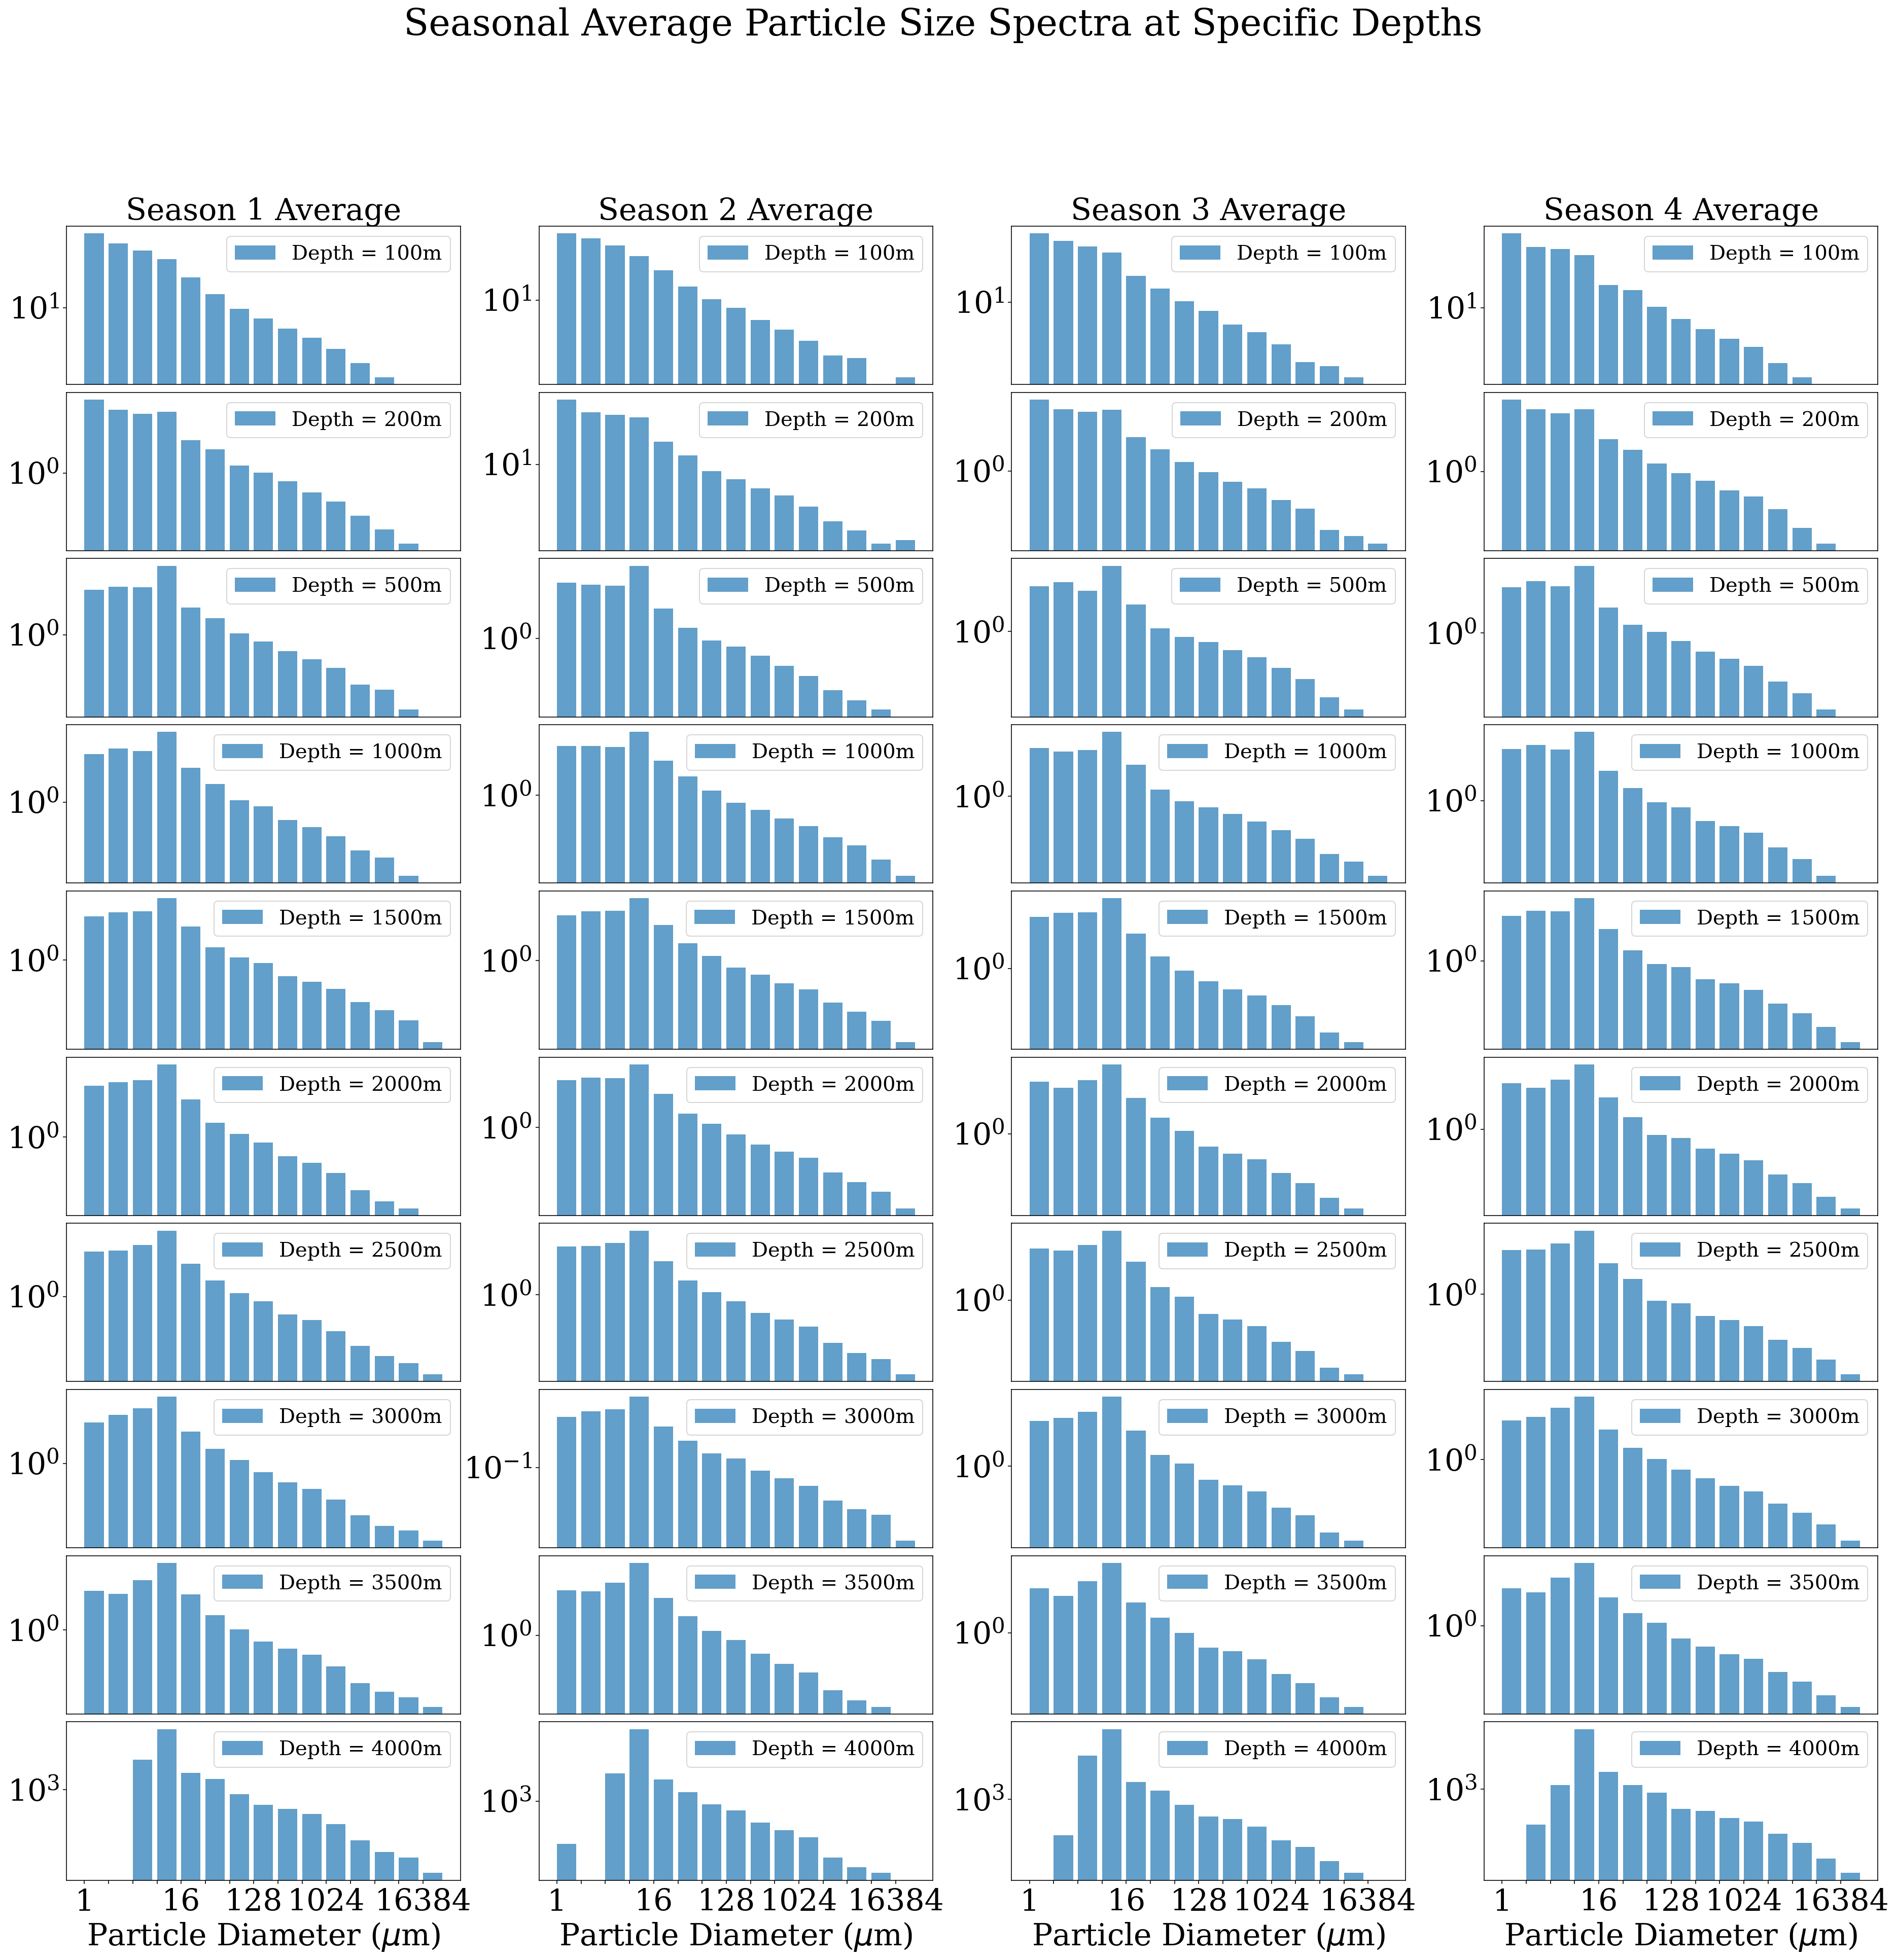

CPU times: user 18.2 s, sys: 89.9 ms, total: 18.3 s
Wall time: 18.6 s


In [6]:
%%time

#plotting the particle number histograms for seasonal average 
avgparticleatt_sizeclass_all['Non_zero'] = (avgparticleatt_sizeclass_all['#_of_particles'] > 0)*1

#seasonal average of the particle sizes
array_of_depth = [100,200,500,1000,1500,2000,2500,3000,3500,4000]

#setting the plotting parameters
params = {
    'image.cmap': 'gray',
    'axes.labelsize': 30, # fontsize for x and y labels (was 10)
    'axes.titlesize': 30,
    'font.size': 30, # was 10
    'legend.fontsize': 20, # was 10
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'figure.figsize': [32, 30],
    'font.family': 'serif',
}

#updating parameters for plotting
matplotlib.rcParams.update(params)

#setting up the graph structure
fig = plt.figure()
fig.suptitle("Seasonal Average Particle Size Spectra at Specific Depths") 
gs = matplotlib.gridspec.GridSpec(10, 4, width_ratios=[1.,1.,1.,1.],
                                  height_ratios=[1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])

gs.update(wspace=0.2, hspace=0.05)

season_labeling_for_plot = np.arange(4)
adding_labeling = np.ones(4)*3
 
#calculating and plotting the seasonal average particle size distribution 
#looping through every depth
for j in range(len(array_of_depth)):
    
    #seasonal average of all sizeclasses at one specific depth
    season1_added = avgparticleatt_sizeclass_all[
        (avgparticleatt_sizeclass_all['depth_reached']== array_of_depth[j])&
        (avgparticleatt_sizeclass_all['season'] == 1)].groupby(
        by='type').sum()[fifteen_atributes+['Non_zero']]
    season1_averaged = season1_added.iloc[:,:-1].div(season1_added['Non_zero'], axis=0).fillna(value=0)

    season2_added = avgparticleatt_sizeclass_all[
        (avgparticleatt_sizeclass_all['depth_reached']== array_of_depth[j])&
        (avgparticleatt_sizeclass_all['season'] == 2)].groupby(
        by='type').sum()[fifteen_atributes+['Non_zero']]
    season2_averaged = season2_added.iloc[:,:-1].div(season2_added['Non_zero'], axis=0).fillna(value=0)

    season3_added = avgparticleatt_sizeclass_all[
        (avgparticleatt_sizeclass_all['depth_reached']== array_of_depth[j])&
        (avgparticleatt_sizeclass_all['season'] == 3)].groupby(
        by='type').sum()[fifteen_atributes+['Non_zero']]
    season3_averaged = season3_added.iloc[:,:-1].div(season3_added['Non_zero'], axis=0).fillna(value=0)

    season4_added = avgparticleatt_sizeclass_all[
        (avgparticleatt_sizeclass_all['depth_reached']== array_of_depth[j])&
        (avgparticleatt_sizeclass_all['season'] == 4)].groupby(
        by='type').sum()[fifteen_atributes+['Non_zero']]
    season4_averaged = season4_added.iloc[:,:-1].div(season4_added['Non_zero'], axis=0).fillna(value=0)
    
    number_of_particles_at_depth = pd.DataFrame(season1_averaged['#_of_particles'])
    number_of_particles_at_depth['Season_2'] = np.array(season2_averaged['#_of_particles'])
    number_of_particles_at_depth['Season_3'] = np.array(season3_averaged['#_of_particles'])
    number_of_particles_at_depth['Season_4'] = np.array(season4_averaged['#_of_particles'])
    

    if j == 0:
        #for correct plot location allocation 
        counter=np.arange(4)
        
        #looping through seasons
        for i in range(len(season_labeling_for_plot)):
            
            #plotting the histograms
            ax1 = fig.add_subplot(gs[season_labeling_for_plot[i]+j])
            
            ax1.bar(number_of_particles_at_depth.index, number_of_particles_at_depth.iloc[:,i],log=True,
                    label='Depth = ' +str(array_of_depth[j]) +'m',align='edge',alpha=0.7)
            
            ax1.legend(loc='upper right')
            ax1.set_title('Season ' + str(i+1) + ' Average')
            ax1.tick_params(top=False, bottom=False, labelleft='on', labelbottom=False)


        
    elif (j<9): #drops all x labels for top subplots
        counter= counter +np.ones(4)*3
        for i in range(len(counter)):
            
            #plotting the histograms
            ax1 = fig.add_subplot(gs[int(counter[i])+j])
            ax1.bar(number_of_particles_at_depth.index, number_of_particles_at_depth.iloc[:,i],log=True,
                    label='Depth = ' +str(array_of_depth[j]) +'m',align='edge',alpha=0.7)
            ax1.legend(loc='upper right')
            
            ax1.tick_params(top=False, bottom=False, labelleft='on', labelbottom=False)

    elif j==9: # labeling the x axis on the bottom two subplots
        counter= counter +np.ones(4)*3
        for i in range(len(counter)):
            
            #plotting the histograms
            ax1 = fig.add_subplot(gs[int(counter[i])+j])
            ax1.bar(number_of_particles_at_depth.index, number_of_particles_at_depth.iloc[:,i],log=True,
                    label='Depth = ' +str(array_of_depth[j]) +'m',align='edge',alpha=0.7)
            ax1.legend(loc='upper right')
            
            ax1.tick_params(bottom=True, labelleft='on', labelbottom=True)
            ax1.set_xticks(number_of_particles_at_depth.index )
            ax1.set_xticklabels(['1','','', '', '16', '', '','128','','','1024','','','','16384'])
            ax1.set_xlabel(r'Particle Diameter ($\mu$m)')


            #ax1.set_xlim(0.5,16)

#saves the figure    
plt.savefig("Seasonal_Average_Particle_Size_Spectra_at_Specific_Depth.png",dpi=200)
plt.show()


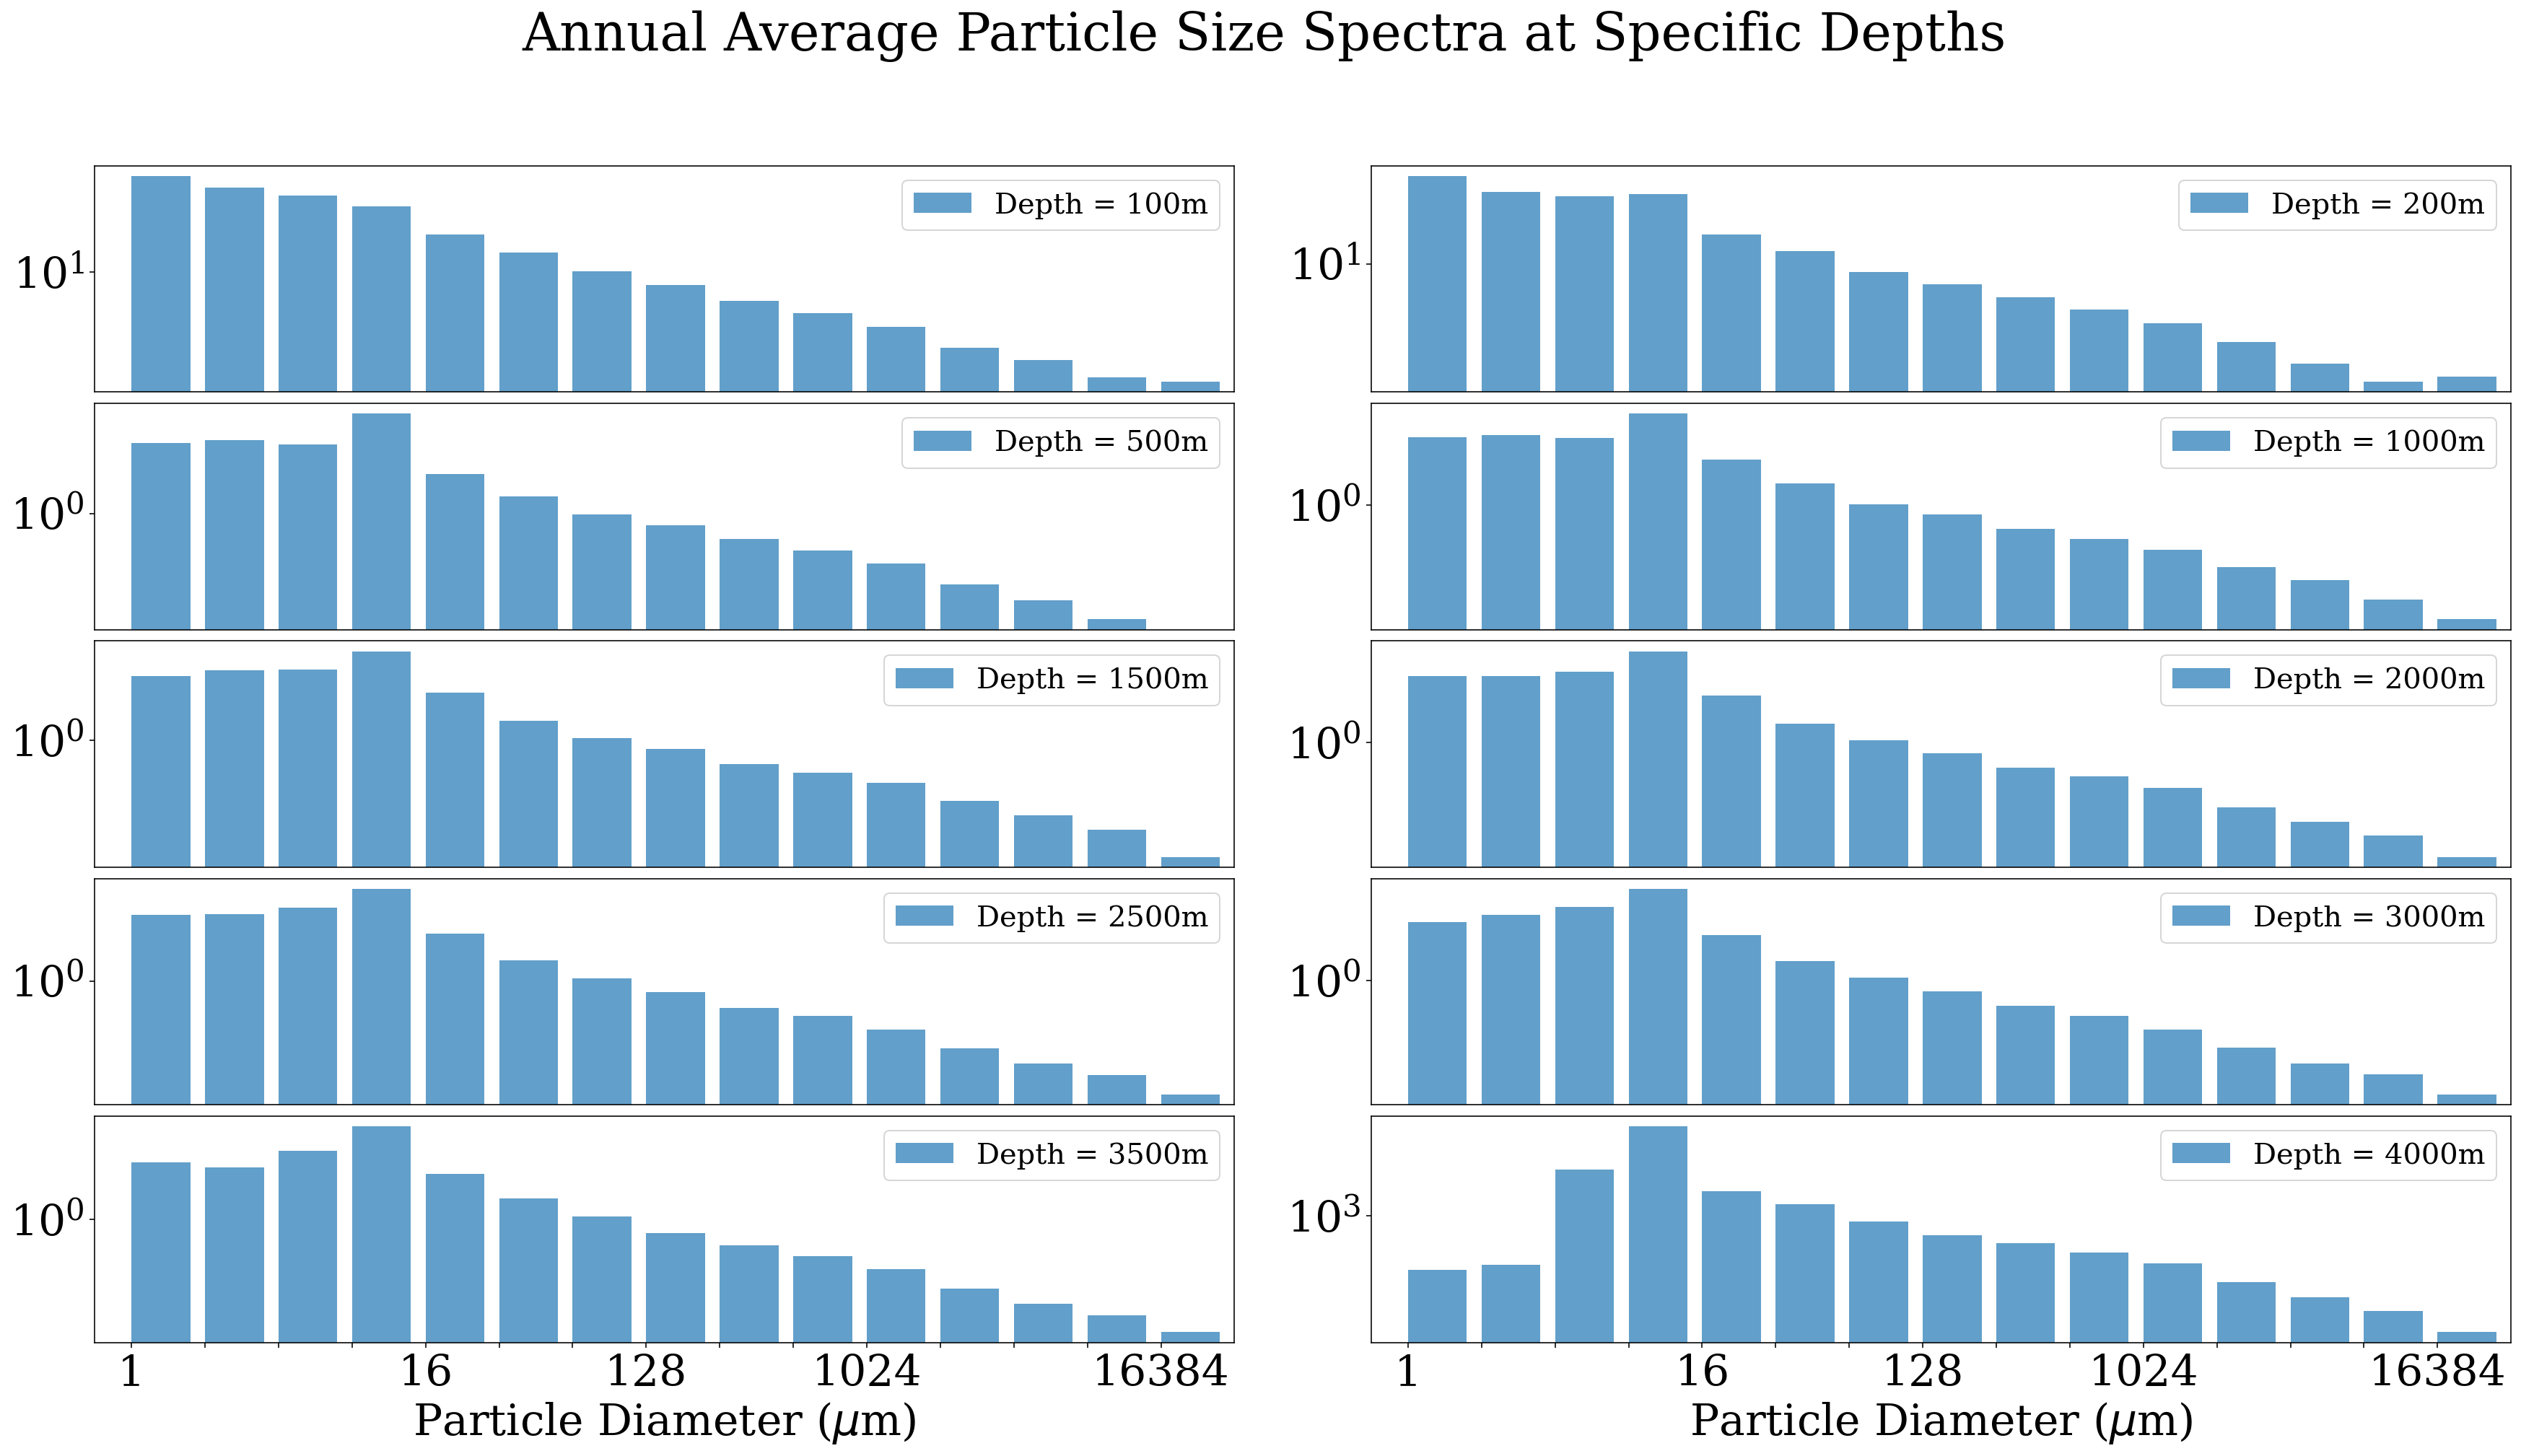

In [7]:
#setting the plotting parameters
params = {
    'image.cmap': 'gray',
    'axes.labelsize': 30, # fontsize for x and y labels (was 10)
    'axes.titlesize': 30,
    'font.size': 30, # was 10
    'legend.fontsize': 20, # was 10
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'figure.figsize': [30, 15],
    'font.family': 'serif',
}

#updating parameters for plotting
matplotlib.rcParams.update(params)

#setting up the graph structure
fig = plt.figure()
fig.suptitle("Annual Average Particle Size Spectra at Specific Depths") 
gs = matplotlib.gridspec.GridSpec(5, 2, width_ratios=[1.,1.], height_ratios=[1.,1.,1.,1.,1.])
gs.update(wspace=0.12, hspace=0.05)

#calculating the seasonal average 

#calculating and plotting the annual average particle size distribution 
#looping through every depth
for j in range(len(array_of_depth)):
    spec_depth_sum = avgparticleatt_sizeclass_all[
        avgparticleatt_sizeclass_all['depth_reached']==array_of_depth[j]].groupby(
        by='type').sum()[fifteen_atributes+['Non_zero']]
    
    annual_average_at_depth =  spec_depth_sum.iloc[:,:-1].div(spec_depth_sum['Non_zero'], axis=0).fillna(value=0)

    #plotting the annual particle size distribution 
    ax1 = fig.add_subplot(gs[j])
    ax1.bar(annual_average_at_depth.index, annual_average_at_depth['#_of_particles'],log=True,
            label='Depth = ' +str(array_of_depth[j]) +'m',align='edge',alpha=0.7)

    if j<=7: #drops all x labels for top subplots
        ax1.tick_params(top=False, bottom=False, labelleft='on', labelbottom=False)

    if j>7: # labeling the x axis on the bottom two subplots
        ax1.tick_params(bottom=True, labelleft='on', labelbottom=True)

        ax1.set_xticks(annual_average_at_depth.index )
        ax1.set_xticklabels(['1','','', '', '16', '', '','128','','','1024','','','','16384'])
        ax1.set_xlabel(r'Particle Diameter ($\mu$m)')

        
    ax1.set_xlim(0.5,16)
    ax1.legend(loc='upper right')

#saves the figure    
plt.savefig("Annual_Average_Particle_Size_Spectra_at_Specific_Depth.png")
plt.show()


### VeloClass Analysis

Here we load the data from `out_avgparticleatt_veloclass.bin` and `out_avgparticleatt_veloclass_seafloor.bin` files. We combine those files together and flatten them into a 2D DataFrame for easier data manipulation and visualisation.

In [8]:
# combining veloclasses files together into 2D DataFrame 
#list of 15 attrinutes
fifteen_atributes = ['#_of_particles', 'density', 'velocity', 'stikiness', 'porosity',
                                            'solid_volume','fractial_dimensions', 'radius_primary_particle',
                                            'depth','mol_organic_carbon','mol_TEPC','mol_opal','nol_calcite',
                                            'mol_aragonite', 'mol_clay']

veloclasses_velocity = [1,1.8,3.2,5.6,10,17.8,31.6,56.2,100,177.8,316.2,562.3,1000,1778.3,3162.3,5623.4,10000]
#sizeclasses_for_hist = [1,10,100,1000,10000]

month_labeling_veloclasses = []
for i in range(1,13):
    month_labeling_veloclasses.append([i]*nVeloClasses)
    
season_labeling_veloclasses = []
for i in range(1,5):
    season_labeling_veloclasses.append([i]*3*nVeloClasses)

season_label_veloclasses = np.array(season_labeling_veloclasses).reshape(12*nVeloClasses)   
month_labeling_veloclasses = np.array(month_labeling_veloclasses).reshape(nVeloClasses*12)

veloclasses_type = list(np.arange(1,nVeloClasses+1))*12

    
avgparticleatt_veloclass_seafloor = pd.DataFrame(
    np.transpose(out_avgparticleatt_veloclass_seafloor[:,:,-12:].reshape(
        nVeloClasses,15,12).byteswap().newbyteorder(),(2,0,1)).reshape(nVeloClasses*12,15))

avgparticleatt_veloclass_seafloor.columns = fifteen_atributes

avgparticleatt_veloclass_seafloor['month'] = month_labeling_veloclasses
avgparticleatt_veloclass_seafloor['type'] = veloclasses_type
avgparticleatt_veloclass_seafloor['depth_reached'] = [
    depth_labeling[int(nImagingDeployDepth)]]*len(avgparticleatt_veloclass_seafloor)
avgparticleatt_veloclass_seafloor['season'] = season_label_veloclasses

#flattening the out_avgparticleatt_maintype.bin into 2D DataFrame
depth_labeling_many_depth_veloclasses = []
for i in depth_labeling:
    depth_labeling_many_depth_veloclasses.append([i]*nVeloClasses*12)

all_depths_veloclass = np.array(depth_labeling_many_depth_veloclasses)[:nImagingDeployDepth,:].reshape(
    nImagingDeployDepth*nVeloClasses*12)

all_month_veloclasses = list(month_labeling_veloclasses)*nImagingDeployDepth
all_types_veloclasses = list(veloclasses_type)*nImagingDeployDepth
all_seasons_veloclasses = list(season_label_veloclasses)*nImagingDeployDepth

#naming the attributes and adding the depth, month and type label
time_transposed_reshaped_vel = np.transpose(
    out_avgparticleatt_veloclass[:,:,:,-12:].byteswap().newbyteorder(), (3,0,1,2)).reshape(
    12*nVeloClasses,nImagingDeployDepth,15)

avgparticleatt_veloclass = pd.DataFrame(np.transpose(
    time_transposed_reshaped_vel, (1,0,2)).reshape(nImagingDeployDepth*nVeloClasses*12,15))
avgparticleatt_veloclass.columns = fifteen_atributes
avgparticleatt_veloclass['type'] = all_types_veloclasses
avgparticleatt_veloclass['month'] = all_month_veloclasses
avgparticleatt_veloclass['depth_reached'] = all_depths_veloclass
avgparticleatt_veloclass['season'] = all_seasons_veloclasses

# final DataFrame with all information from out_avgparticleatt_veloclass_seafloor.bin 
# and out_avgparticleatt_veloclass.bin
avgparticleatt_veloclass_all = pd.concat(
    (avgparticleatt_veloclass, avgparticleatt_veloclass_seafloor)).reset_index(drop=True)

#prints the DataFrame
avgparticleatt_veloclass_all



#_of_particles   density    velocity     stikiness  porosity  \
0       2.807055e+06  1.060089    0.592673  6.293529e-05  0.000047   
1       8.191029e+03  2.142291    2.963877  6.098768e-05  0.001691   
2       1.148341e+04  2.152842    3.644204  6.912782e-05  0.000675   
3       4.733006e+03  2.156346    4.276154  7.000006e-06  0.000092   
4       4.823429e+01  1.274287   13.504200  1.676563e-03  0.004395   
...              ...       ...         ...           ...       ...   
6319    3.932051e+00  1.311436  286.127769  4.653416e-03  0.512354   
6320    5.344346e+00  1.792368  206.444911  2.643341e-06  0.264888   
6321    4.201398e+00  2.038569  210.447417  6.981667e-09  0.097928   
6322    1.201456e+00  2.017173  303.799524  0.000000e+00  0.095097   
6323    0.000000e+00  0.000000    0.000000  0.000000e+00  0.000000   

      solid_volume  fractial_dimensions  radius_primary_particle        depth  \
0     1.687705e+00             2.999896                 0.592481     5.000412   
1     1.338368e+02             2.996525                 2.952411     5.277526   
2     2.497500e+02             2.998635                 3.638758     5.691817   
3     5.308949e+02             2.999774                 4.273224     6.060517   
4     1.173754e+04             2.989526                13.324485     6.030539   
...            ...                  ...                      ...          ...   
6319  1.924306e+07             2.161343                81.762642  3870.000000   
6320  2.615604e+07             2.571401               110.239695  3870.000000   
6321  4.459853e+07             2.818980               167.409427  3870.000000   
6322  1.312267e+08             2.805474               247.947898  3870.000000   
6323  0.000000e+00             0.000000                 0.000000     0.000000   

      mol_organic_carbon      mol_TEPC      mol_opal   nol_calcite  \
0           7.877046e-14  7.445369e-17  3.431332e-16  3.883773e-21   
1           3.171779e-12  1.357317e-14  4.251193e-14  1.779491e-12   
2           5.965035e-12  1.003861e-14  5.551751e-14  3.429773e-12   
3           1.615587e-11  3.033384e-15  4.055555e-14  5.425020e-12   
4           4.325525e-10  6.560816e-13  4.964653e-11  1.230886e-15   
...                  ...           ...           ...           ...   
6319        3.807167e-07  2.968592e-09  1.548286e-07  6.349135e-08   
6320        5.937204e-07  9.265877e-13  2.229364e-07  6.941160e-08   
6321        9.148222e-07  4.178246e-15  3.128991e-07  1.669555e-07   
6322        2.867714e-06  0.000000e+00  8.311635e-07  4.465289e-07   
6323        0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

      mol_aragonite      mol_clay  type  month  depth_reached  season  
0      0.000000e+00  3.218025e-17     1      1             10       1  
1      0.000000e+00  4.232505e-15     2      1             10       1  
2      0.000000e+00  1.803964e-15     3      1             10       1  
3      0.000000e+00  5.071161e-16     4      1             10       1  
4      0.000000e+00  2.279693e-13     5      1             10       1  
...             ...           ...   ...    ...            ...     ...  
6319   2.337764e-09  6.370217e-09    13     12           4000       4  
6320   9.784927e-27  6.046601e-12    14     12           4000       4  
6321   1.087290e-07  2.518907e-13    15     12           4000       4  
6322   3.893430e-07  0.000000e+00    16     12           4000       4  
6323   0.000000e+00  0.000000e+00    17     12           4000       4  

[6324 rows x 19 columns]

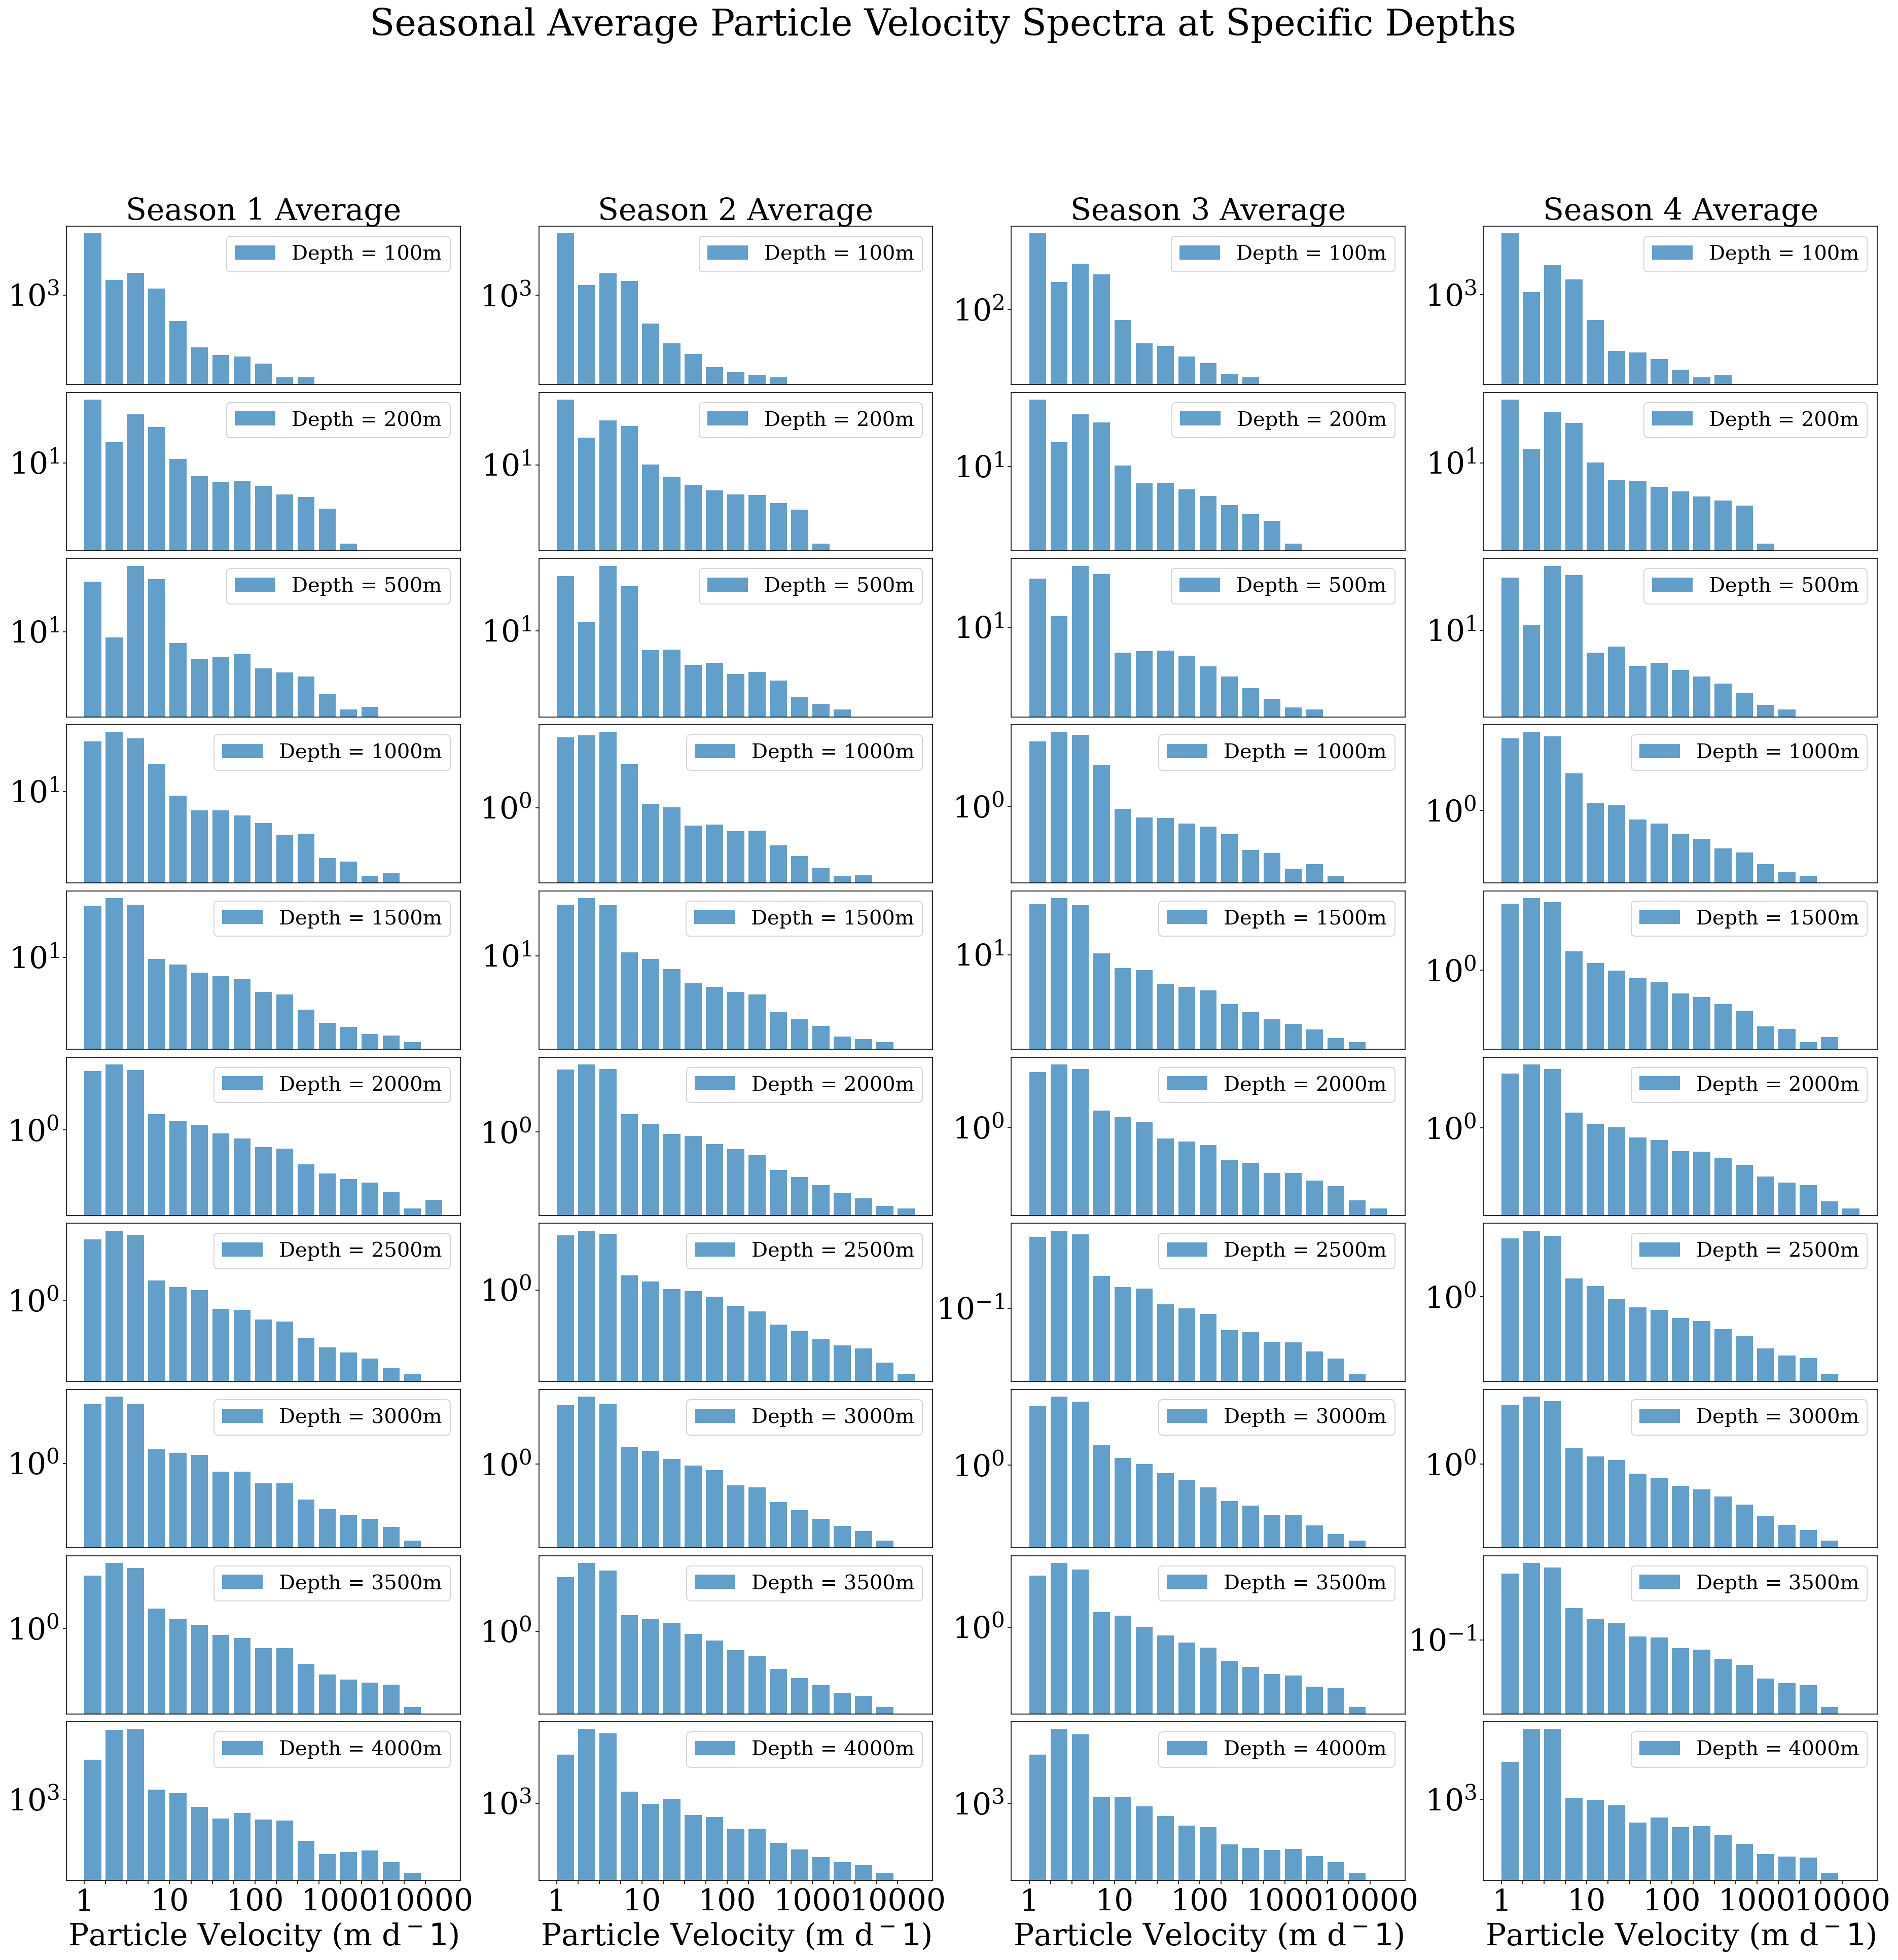

CPU times: user 17 s, sys: 143 ms, total: 17.1 s
Wall time: 17.2 s


In [9]:
%%time

#plotting the particle number histograms for seasonal average 
avgparticleatt_veloclass_all['Non_zero'] = (avgparticleatt_veloclass_all['#_of_particles'] > 0)*1

#seasonal average of the particle sizes
array_of_depth = [100,200,500,1000,1500,2000,2500,3000,3500,4000]

#setting the plotting parameters
params = {
    'image.cmap': 'gray',
    'axes.labelsize': 30, # fontsize for x and y labels (was 10)
    'axes.titlesize': 30,
    'font.size': 30, # was 10
    'legend.fontsize': 20, # was 10
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'figure.figsize': [32, 30],
    'font.family': 'serif',
}

#updating parameters for plotting
matplotlib.rcParams.update(params)

#setting up the graph structure
fig = plt.figure()
fig.suptitle("Seasonal Average Particle Velocity Spectra at Specific Depths") 
gs = matplotlib.gridspec.GridSpec(10, 4, width_ratios=[1.,1.,1.,1.],
                                  height_ratios=[1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])

gs.update(wspace=0.2, hspace=0.05)
 
#calculating and plotting the seasonal average particle size distribution 
#looping through every depth
for j in range(len(array_of_depth)):
    
    #seasonal average of all sizeclasses at one specific depth
    season1_added = avgparticleatt_veloclass_all[
        (avgparticleatt_veloclass_all['depth_reached']== array_of_depth[j])&
        (avgparticleatt_veloclass_all['season'] == 1)].groupby(
        by='type').sum()[fifteen_atributes+['Non_zero']]
    season1_averaged = season1_added.iloc[:,:-1].div(season1_added['Non_zero'], axis=0).fillna(value=0)

    season2_added = avgparticleatt_veloclass_all[
        (avgparticleatt_veloclass_all['depth_reached']== array_of_depth[j])&
        (avgparticleatt_veloclass_all['season'] == 2)].groupby(
        by='type').sum()[fifteen_atributes+['Non_zero']]
    season2_averaged = season2_added.iloc[:,:-1].div(season2_added['Non_zero'], axis=0).fillna(value=0)

    season3_added = avgparticleatt_veloclass_all[
        (avgparticleatt_veloclass_all['depth_reached']== array_of_depth[j])&
        (avgparticleatt_veloclass_all['season'] == 3)].groupby(
        by='type').sum()[fifteen_atributes+['Non_zero']]
    season3_averaged = season3_added.iloc[:,:-1].div(season3_added['Non_zero'], axis=0).fillna(value=0)

    season4_added = avgparticleatt_veloclass_all[
        (avgparticleatt_veloclass_all['depth_reached']== array_of_depth[j])&
        (avgparticleatt_veloclass_all['season'] == 4)].groupby(
        by='type').sum()[fifteen_atributes+['Non_zero']]
    season4_averaged = season4_added.iloc[:,:-1].div(season4_added['Non_zero'], axis=0).fillna(value=0)
    
    number_of_particles_at_depth = pd.DataFrame(season1_averaged['#_of_particles'])
    number_of_particles_at_depth['Season_2'] = np.array(season2_averaged['#_of_particles'])
    number_of_particles_at_depth['Season_3'] = np.array(season3_averaged['#_of_particles'])
    number_of_particles_at_depth['Season_4'] = np.array(season4_averaged['#_of_particles'])
    

    if j == 0:
        #for correct plot location allocation 
        counter=np.arange(4)
        
        #looping through seasons
        for i in range(len(season_labeling_for_plot)):
            
            #plotting the histograms
            ax1 = fig.add_subplot(gs[season_labeling_for_plot[i]+j])
            
            ax1.bar(number_of_particles_at_depth.index, number_of_particles_at_depth.iloc[:,i],log=True,
                    label='Depth = ' +str(array_of_depth[j]) +'m',align='edge',alpha=0.7)
            
            ax1.legend(loc='upper right')
            ax1.set_title('Season ' + str(i+1) + ' Average')
            ax1.tick_params(top=False, bottom=False, labelleft='on', labelbottom=False)


        
    elif (j<9): #drops all x labels for top subplots
        counter= counter +np.ones(4)*3
        for i in range(len(counter)):
            
            #plotting the histograms
            ax1 = fig.add_subplot(gs[int(counter[i])+j])
            ax1.bar(number_of_particles_at_depth.index, number_of_particles_at_depth.iloc[:,i],log=True,
                    label='Depth = ' +str(array_of_depth[j]) +'m',align='edge',alpha=0.7)
            ax1.legend(loc='upper right')
            
            ax1.tick_params(top=False, bottom=False, labelleft='on', labelbottom=False)

    elif j==9: # labeling the x axis on the bottom two subplots
        counter= counter +np.ones(4)*3
        for i in range(len(counter)):
            
            #plotting the histograms
            ax1 = fig.add_subplot(gs[int(counter[i])+j])
            ax1.bar(number_of_particles_at_depth.index, number_of_particles_at_depth.iloc[:,i],log=True,
                    label='Depth = ' +str(array_of_depth[j]) +'m',align='edge',alpha=0.7)
            ax1.legend(loc='upper right')
            
            ax1.tick_params(bottom=True, labelleft='on', labelbottom=True)
            ax1.set_xticks(number_of_particles_at_depth.index )
            ax1.set_xticklabels(['1','','','','10','','','','100','','','','1000','','','','10000'])
            ax1.set_xlabel(r'Particle Velocity (m d$^-1$)')

#saves the figure    
plt.savefig("Seasonal_Average_Particle_Velocity_Spectra_at_Specific_Depth.png",dpi=200)
plt.show()


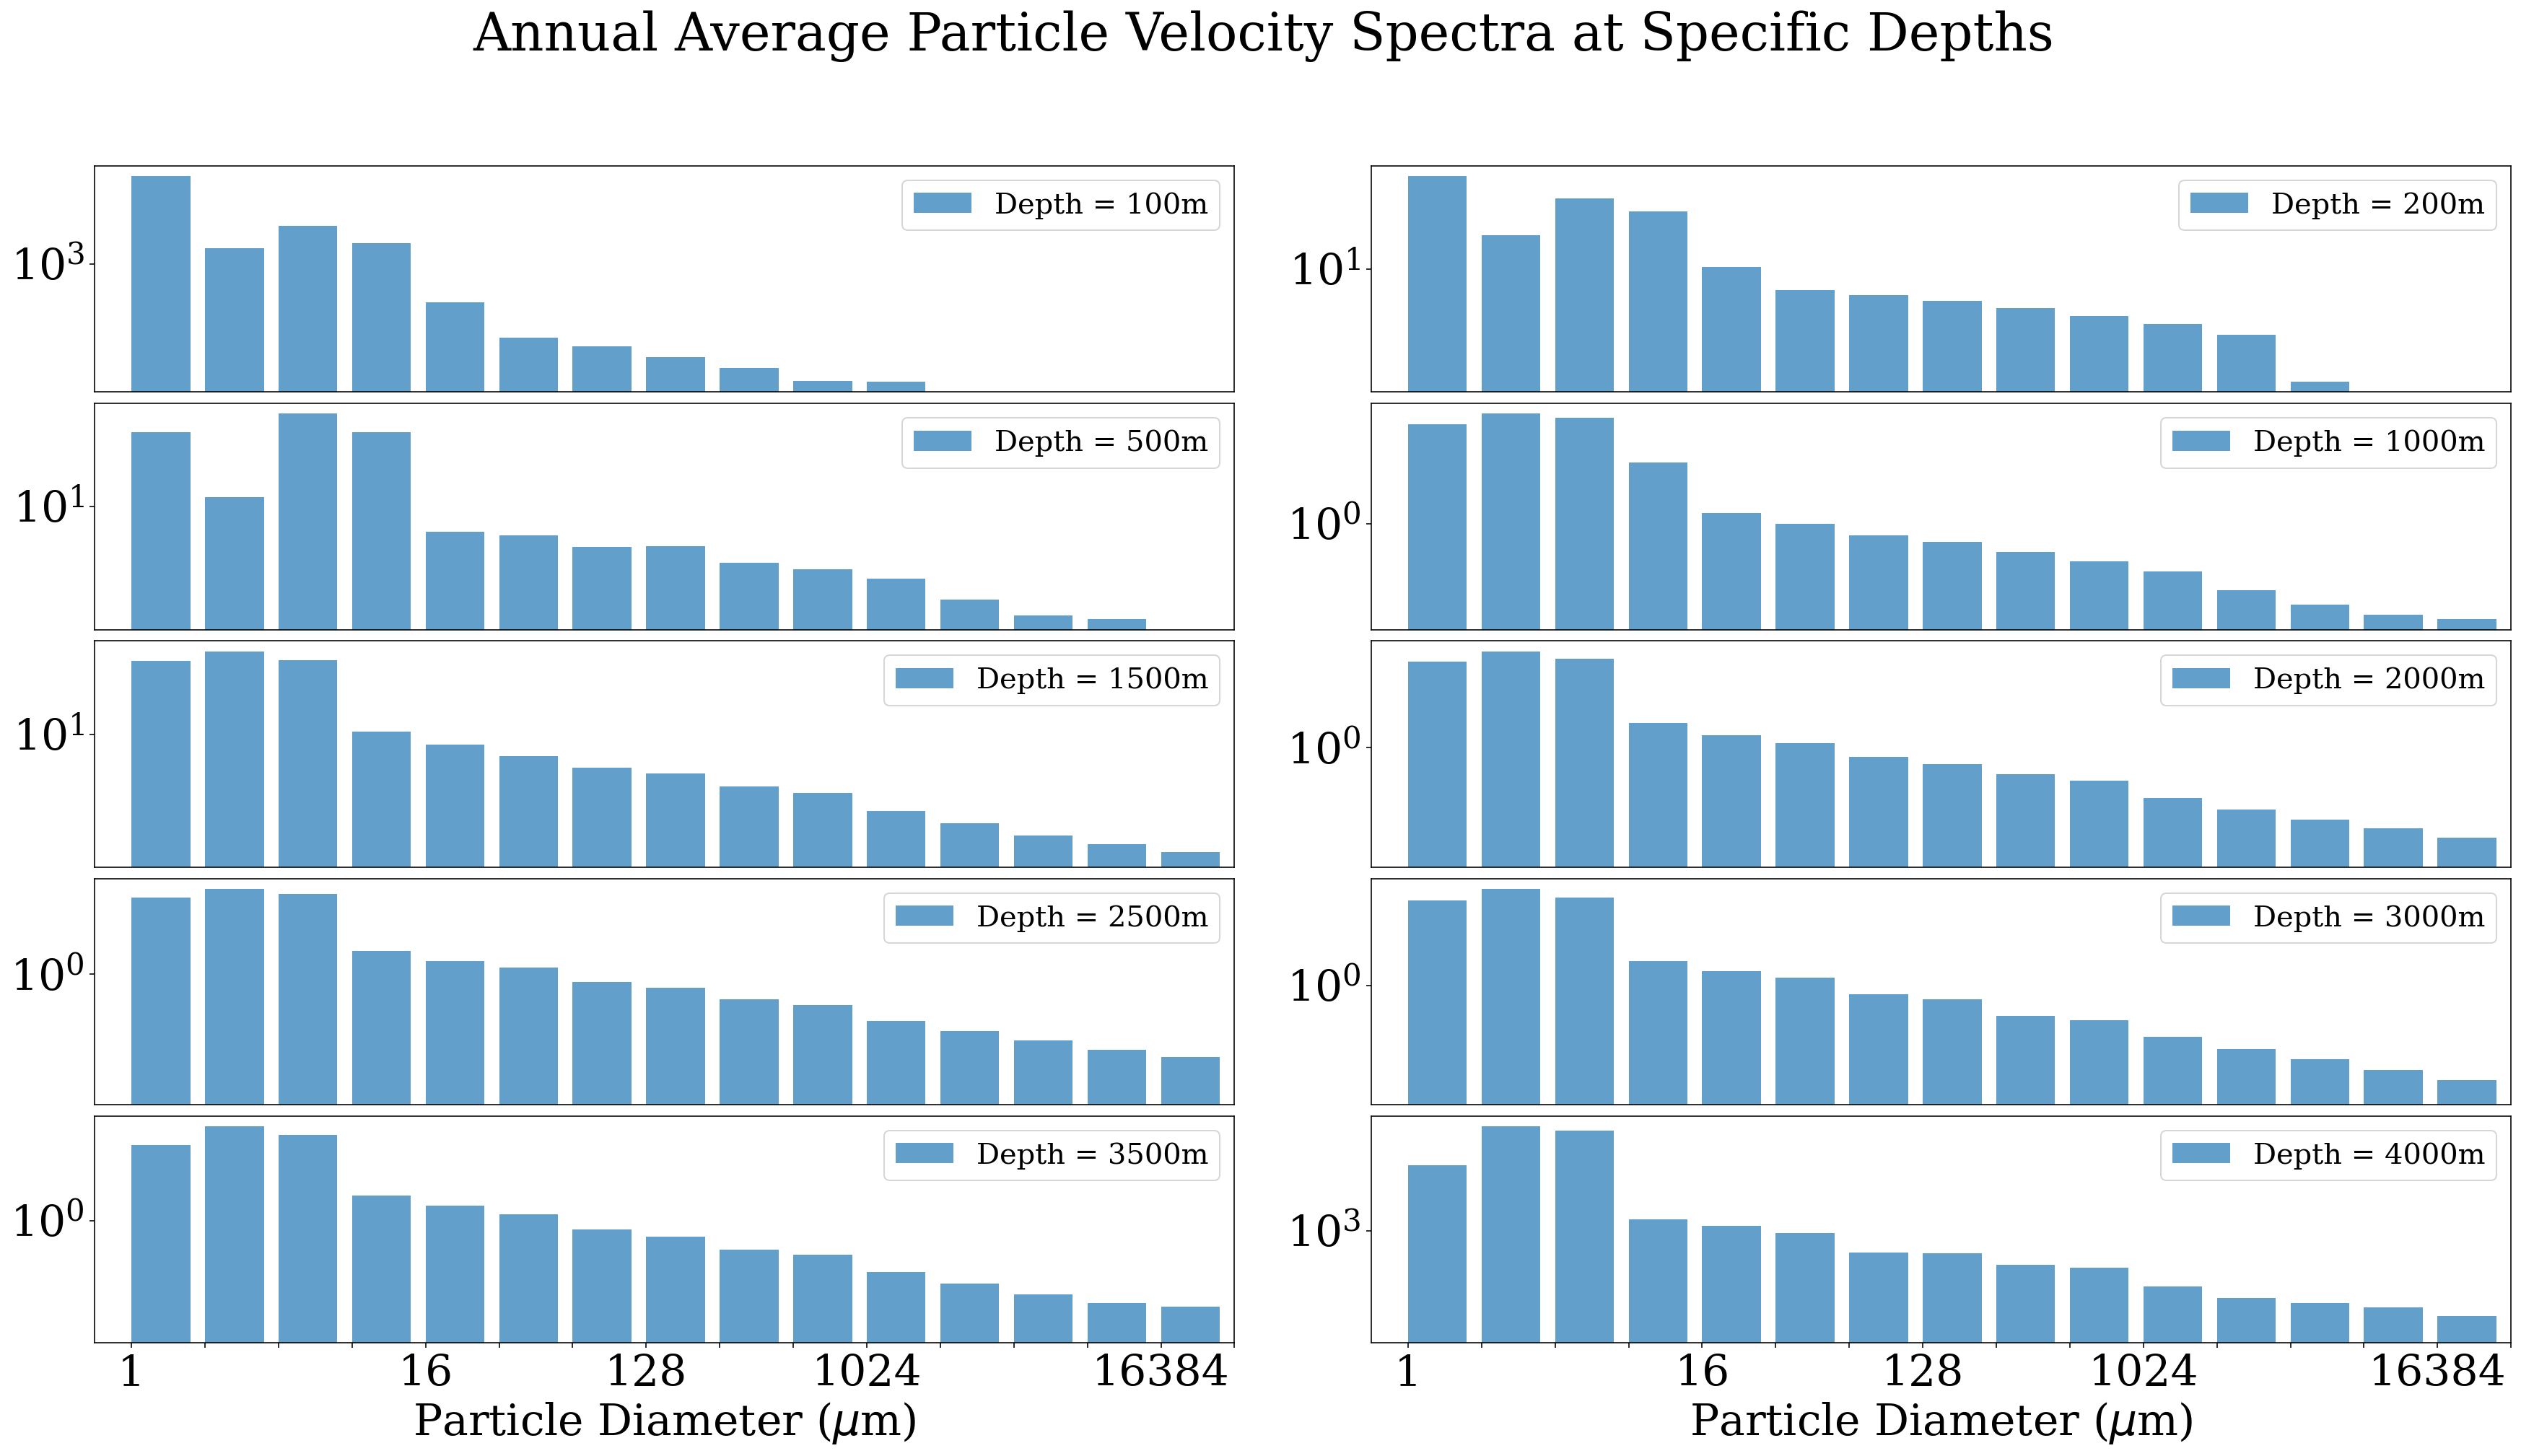

In [10]:
#setting the plotting parameters
params = {
    'image.cmap': 'gray',
    'axes.labelsize': 30, # fontsize for x and y labels (was 10)
    'axes.titlesize': 30,
    'font.size': 30, # was 10
    'legend.fontsize': 20, # was 10
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'figure.figsize': [30, 15],
    'font.family': 'serif',
}

#updating parameters for plotting
matplotlib.rcParams.update(params)

#setting up the graph structure
fig = plt.figure()
fig.suptitle("Annual Average Particle Velocity Spectra at Specific Depths") 
gs = matplotlib.gridspec.GridSpec(5, 2, width_ratios=[1.,1.], height_ratios=[1.,1.,1.,1.,1.])
gs.update(wspace=0.12, hspace=0.05)

#calculating the seasonal average 

#calculating and plotting the annual average particle size distribution 
#looping through every depth
for j in range(len(array_of_depth)):
    spec_depth_sum = avgparticleatt_veloclass_all[
        avgparticleatt_veloclass_all['depth_reached']==array_of_depth[j]].groupby(
        by='type').sum()[fifteen_atributes+['Non_zero']]
    
    annual_average_at_depth =  spec_depth_sum.iloc[:,:-1].div(spec_depth_sum['Non_zero'], axis=0).fillna(value=0)

    #plotting the annual particle size distribution 
    ax1 = fig.add_subplot(gs[j])
    ax1.bar(annual_average_at_depth.index, annual_average_at_depth['#_of_particles'],log=True,
            label='Depth = ' +str(array_of_depth[j]) +'m',align='edge',alpha=0.7)

    if j<=7: #drops all x labels for top subplots
        ax1.tick_params(top=False, bottom=False, labelleft='on', labelbottom=False)

    if j>7: # labeling the x axis on the bottom two subplots
        ax1.tick_params(bottom=True, labelleft='on', labelbottom=True)

        ax1.set_xticks(annual_average_at_depth.index )
        ax1.set_xticklabels(['1','','', '', '16', '', '','128','','','1024','','','','16384'])
        ax1.set_xlabel(r'Particle Diameter ($\mu$m)')

        
    ax1.set_xlim(0.5,16)
    ax1.legend(loc='upper right')

#saves the figure    
plt.savefig("Annual_Average_Particle_Velocity_Spectra_at_Specific_Depth.png")
plt.show()

### Fitting the Power Law

In [227]:
spec_depth_sum = avgparticleatt_sizeclass_all[
    avgparticleatt_sizeclass_all['depth_reached']==100].groupby(
    by='type').sum()[fifteen_atributes+['Non_zero']]

annual_average_at_depth =  spec_depth_sum.iloc[:,:-1].div(spec_depth_sum['Non_zero'], axis=0).fillna(value=0)

Fitted amplitude power 14.994321179283576 +/- 0.4915960385858912
Fitted power law index -2.8416687813607524 +/- 0.08621751931367562
Goodness of fit, r-squared: 0.9864776434369116


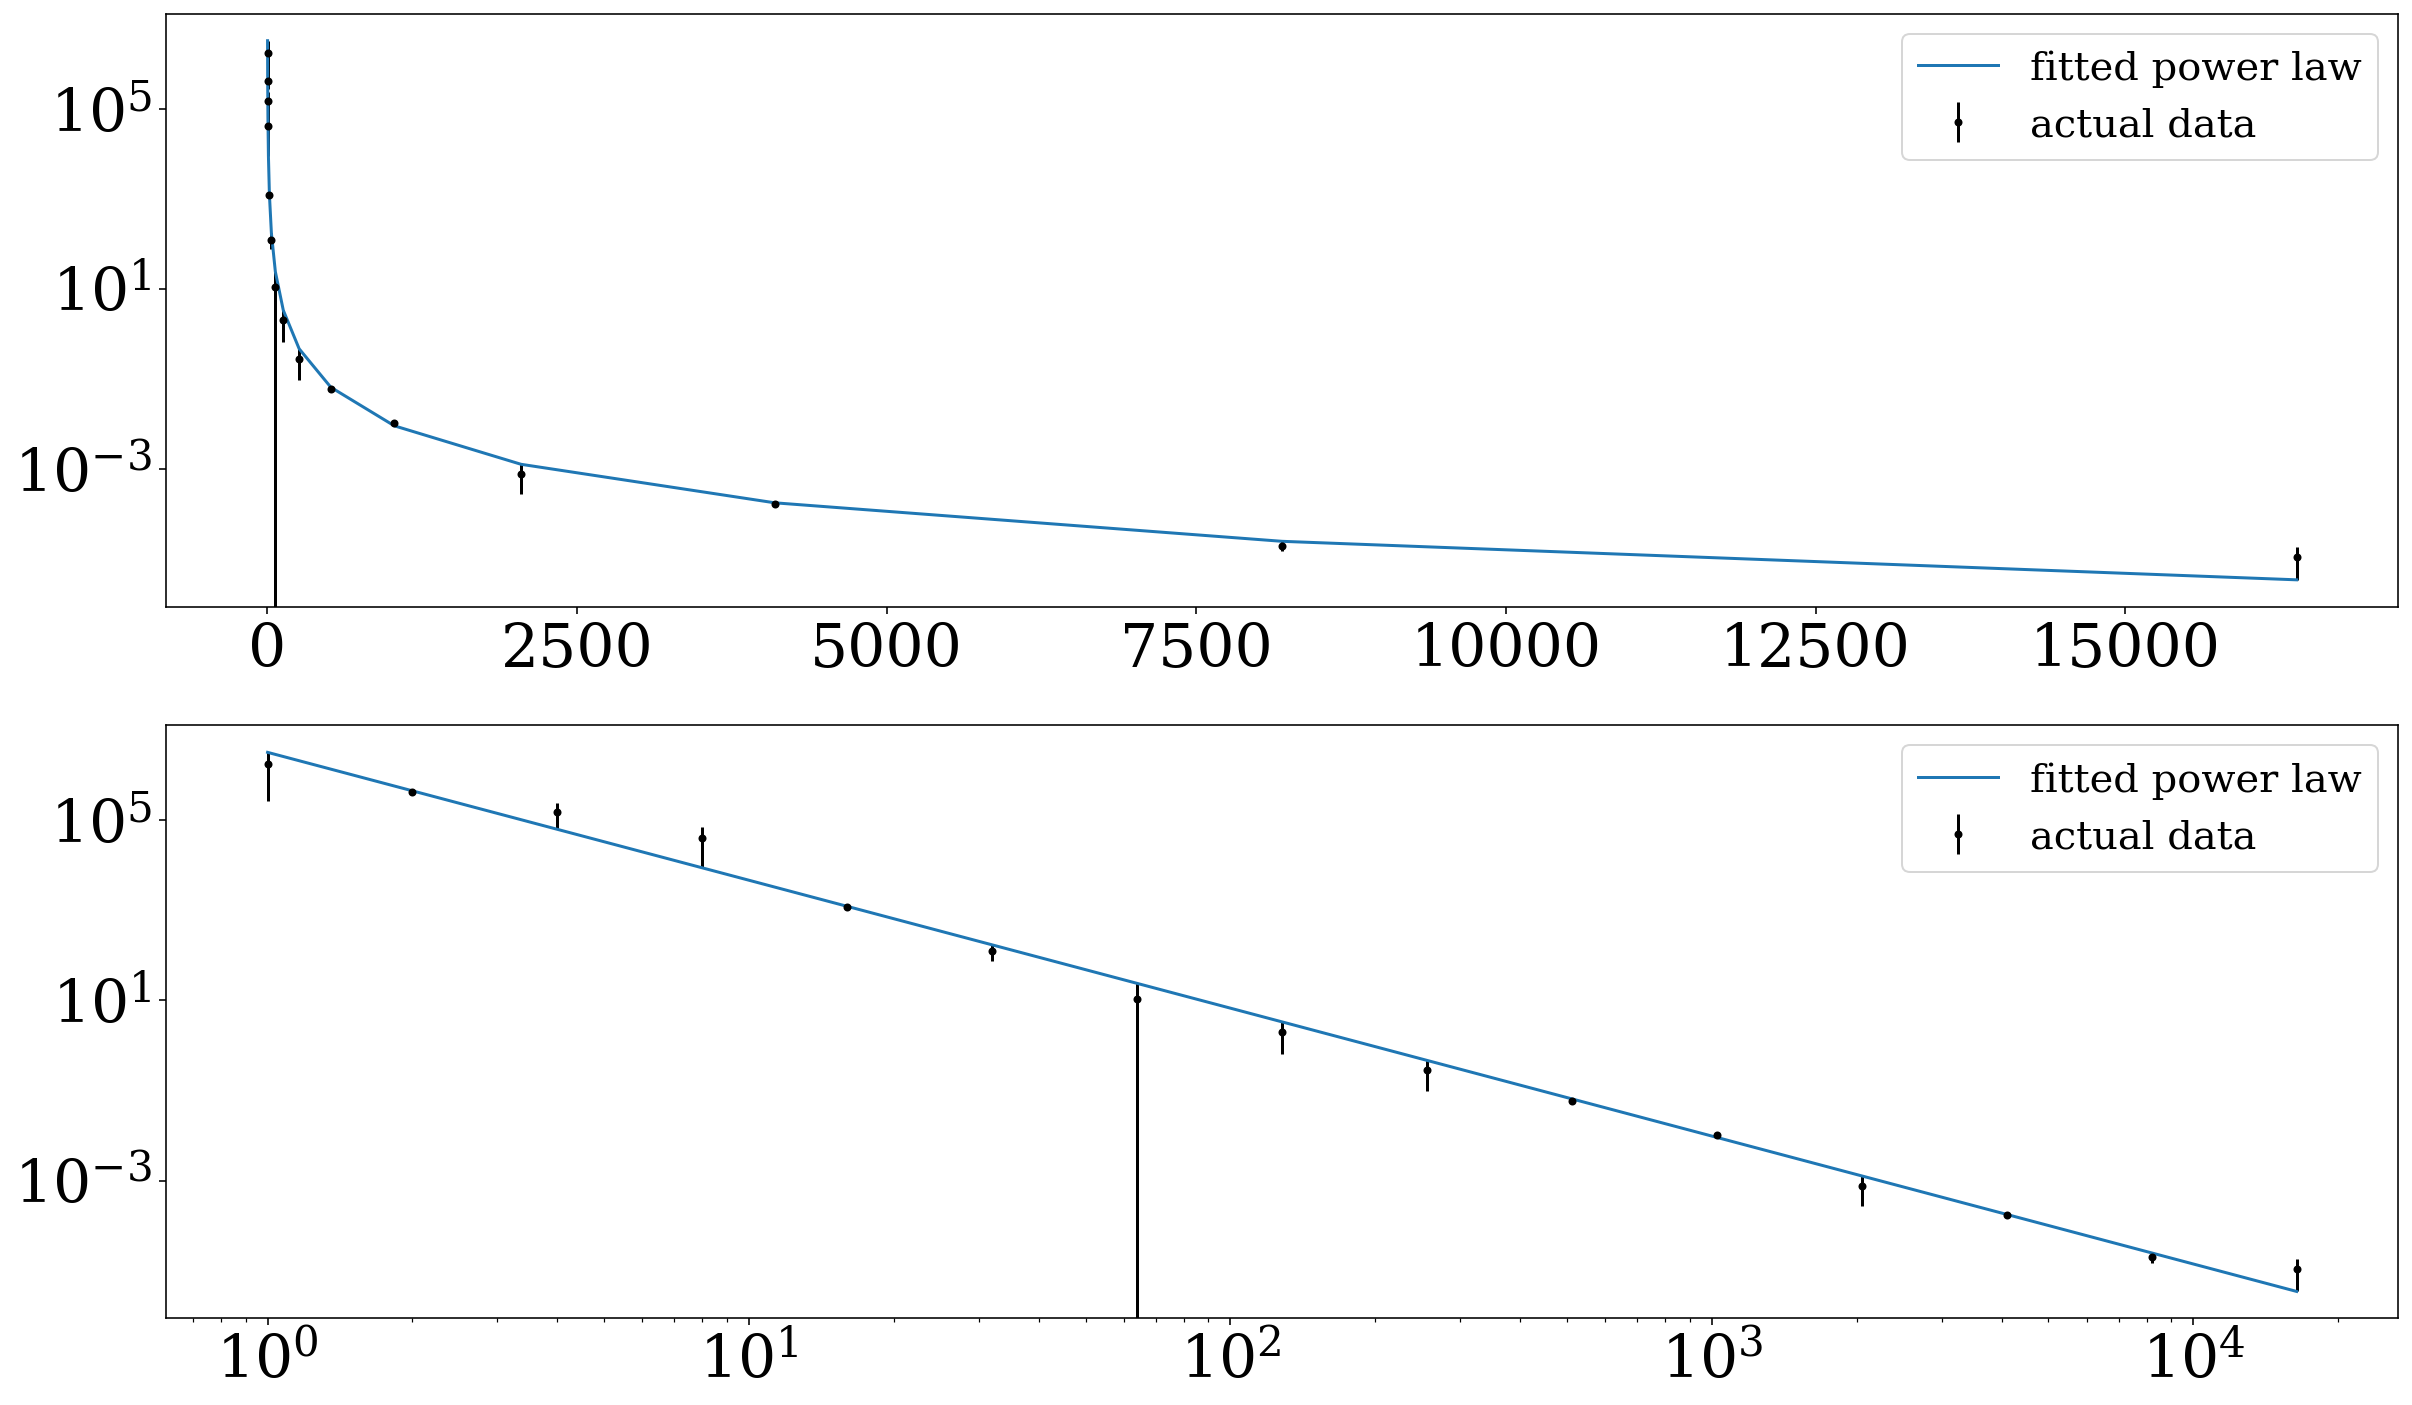

In [296]:
import scipy.optimize as opt
from sklearn.metrics import r2_score



#setting the plotting parameters
params = {
    'image.cmap': 'gray',
    'axes.labelsize': 30, # fontsize for x and y labels (was 10)
    'axes.titlesize': 30,
    'font.size': 30, # was 10
    'legend.fontsize': 20, # was 10
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'figure.figsize': [20, 12],
    'font.family': 'serif',
}

#updating parameters for plotting
matplotlib.rcParams.update(params)

# Define function for calculating a power law
powerlaw = lambda x, amp, index: amp * (x**index)

#  y = a * x^b
#  log(y) = log(a) + b*log(x)

# define our (line) fitting function
fitfunc = lambda p, x: p[0] + p[1] * x
errfunc = lambda p, x, y: y - fitfunc(p, x)

pinit = [1.0, -1.0]

out = opt.leastsq(errfunc, pinit,
                          args=(np.log(sizeclass_sizes), np.log(annual_average_at_depth['#_of_particles'])),
                          full_output=1)
pfinal = out[0]
covar = out[1]

index = pfinal[1]
amp = math.exp(pfinal[0])

stdevs = np.sqrt(np.diag(covar))
print (r'Fitted amplitude power {} +/- {}'.format(pfinal[0], stdevs[0]))
print(r'Fitted power law index {} +/- {}'.format(pfinal[1], stdevs[1]))

yerr = np.array(annual_average_at_depth['#_of_particles']) - powerlaw(sizeclass_sizes, amp, index)

corr_matrix = np.corrcoef(np.array(annual_average_at_depth['#_of_particles']),
                          powerlaw(sizeclass_sizes, amp, index))


print("Goodness of fit, r-squared: {}".format((corr_matrix[0,1])**2))



plt.subplot(2, 1, 1)
plt.plot(sizeclass_sizes,powerlaw(sizeclass_sizes, amp, index),label='fitted power law')
plt.errorbar(sizeclass_sizes, annual_average_at_depth['#_of_particles'],
             yerr=yerr, fmt='k.', label='actual data')  # Data
plt.legend(loc='best')
plt.yscale('log')


plt.subplot(2,1,2)
plt.loglog(sizeclass_sizes,powerlaw(sizeclass_sizes, amp, index),label='fitted power law')
#plt.loglog(sizeclass_sizes, annual_average_at_depth['#_of_particles'],label='actual data')
plt.errorbar(sizeclass_sizes, annual_average_at_depth['#_of_particles'],
             yerr=yerr, fmt='k.', label='actual data')  # Data
plt.legend(loc='best')
plt.show()


## Flux Analysis

In the cells below we present the code that combines the `out_flux.bin` and `out_flux_seafloor.bin` files and puts them in the correct format for ML application.


In [17]:
out_flux.shape

(5, 30, 12)

In [18]:
out_flux_seafloor.shape

(5, 1, 12)

In [13]:
flux_all = np.concatenate((out_flux, out_flux_seafloor), axis=1)
poc, tepc, calcite, aragonite, opal = flux_all 
poc_new = poc + tepc
pic = calcite + aragonite

#combining the arrays back together for finl images
all_flux = np.concatenate((poc_new.reshape(1,31,12), pic.reshape(1,31,12),opal.reshape(1,31,12)))

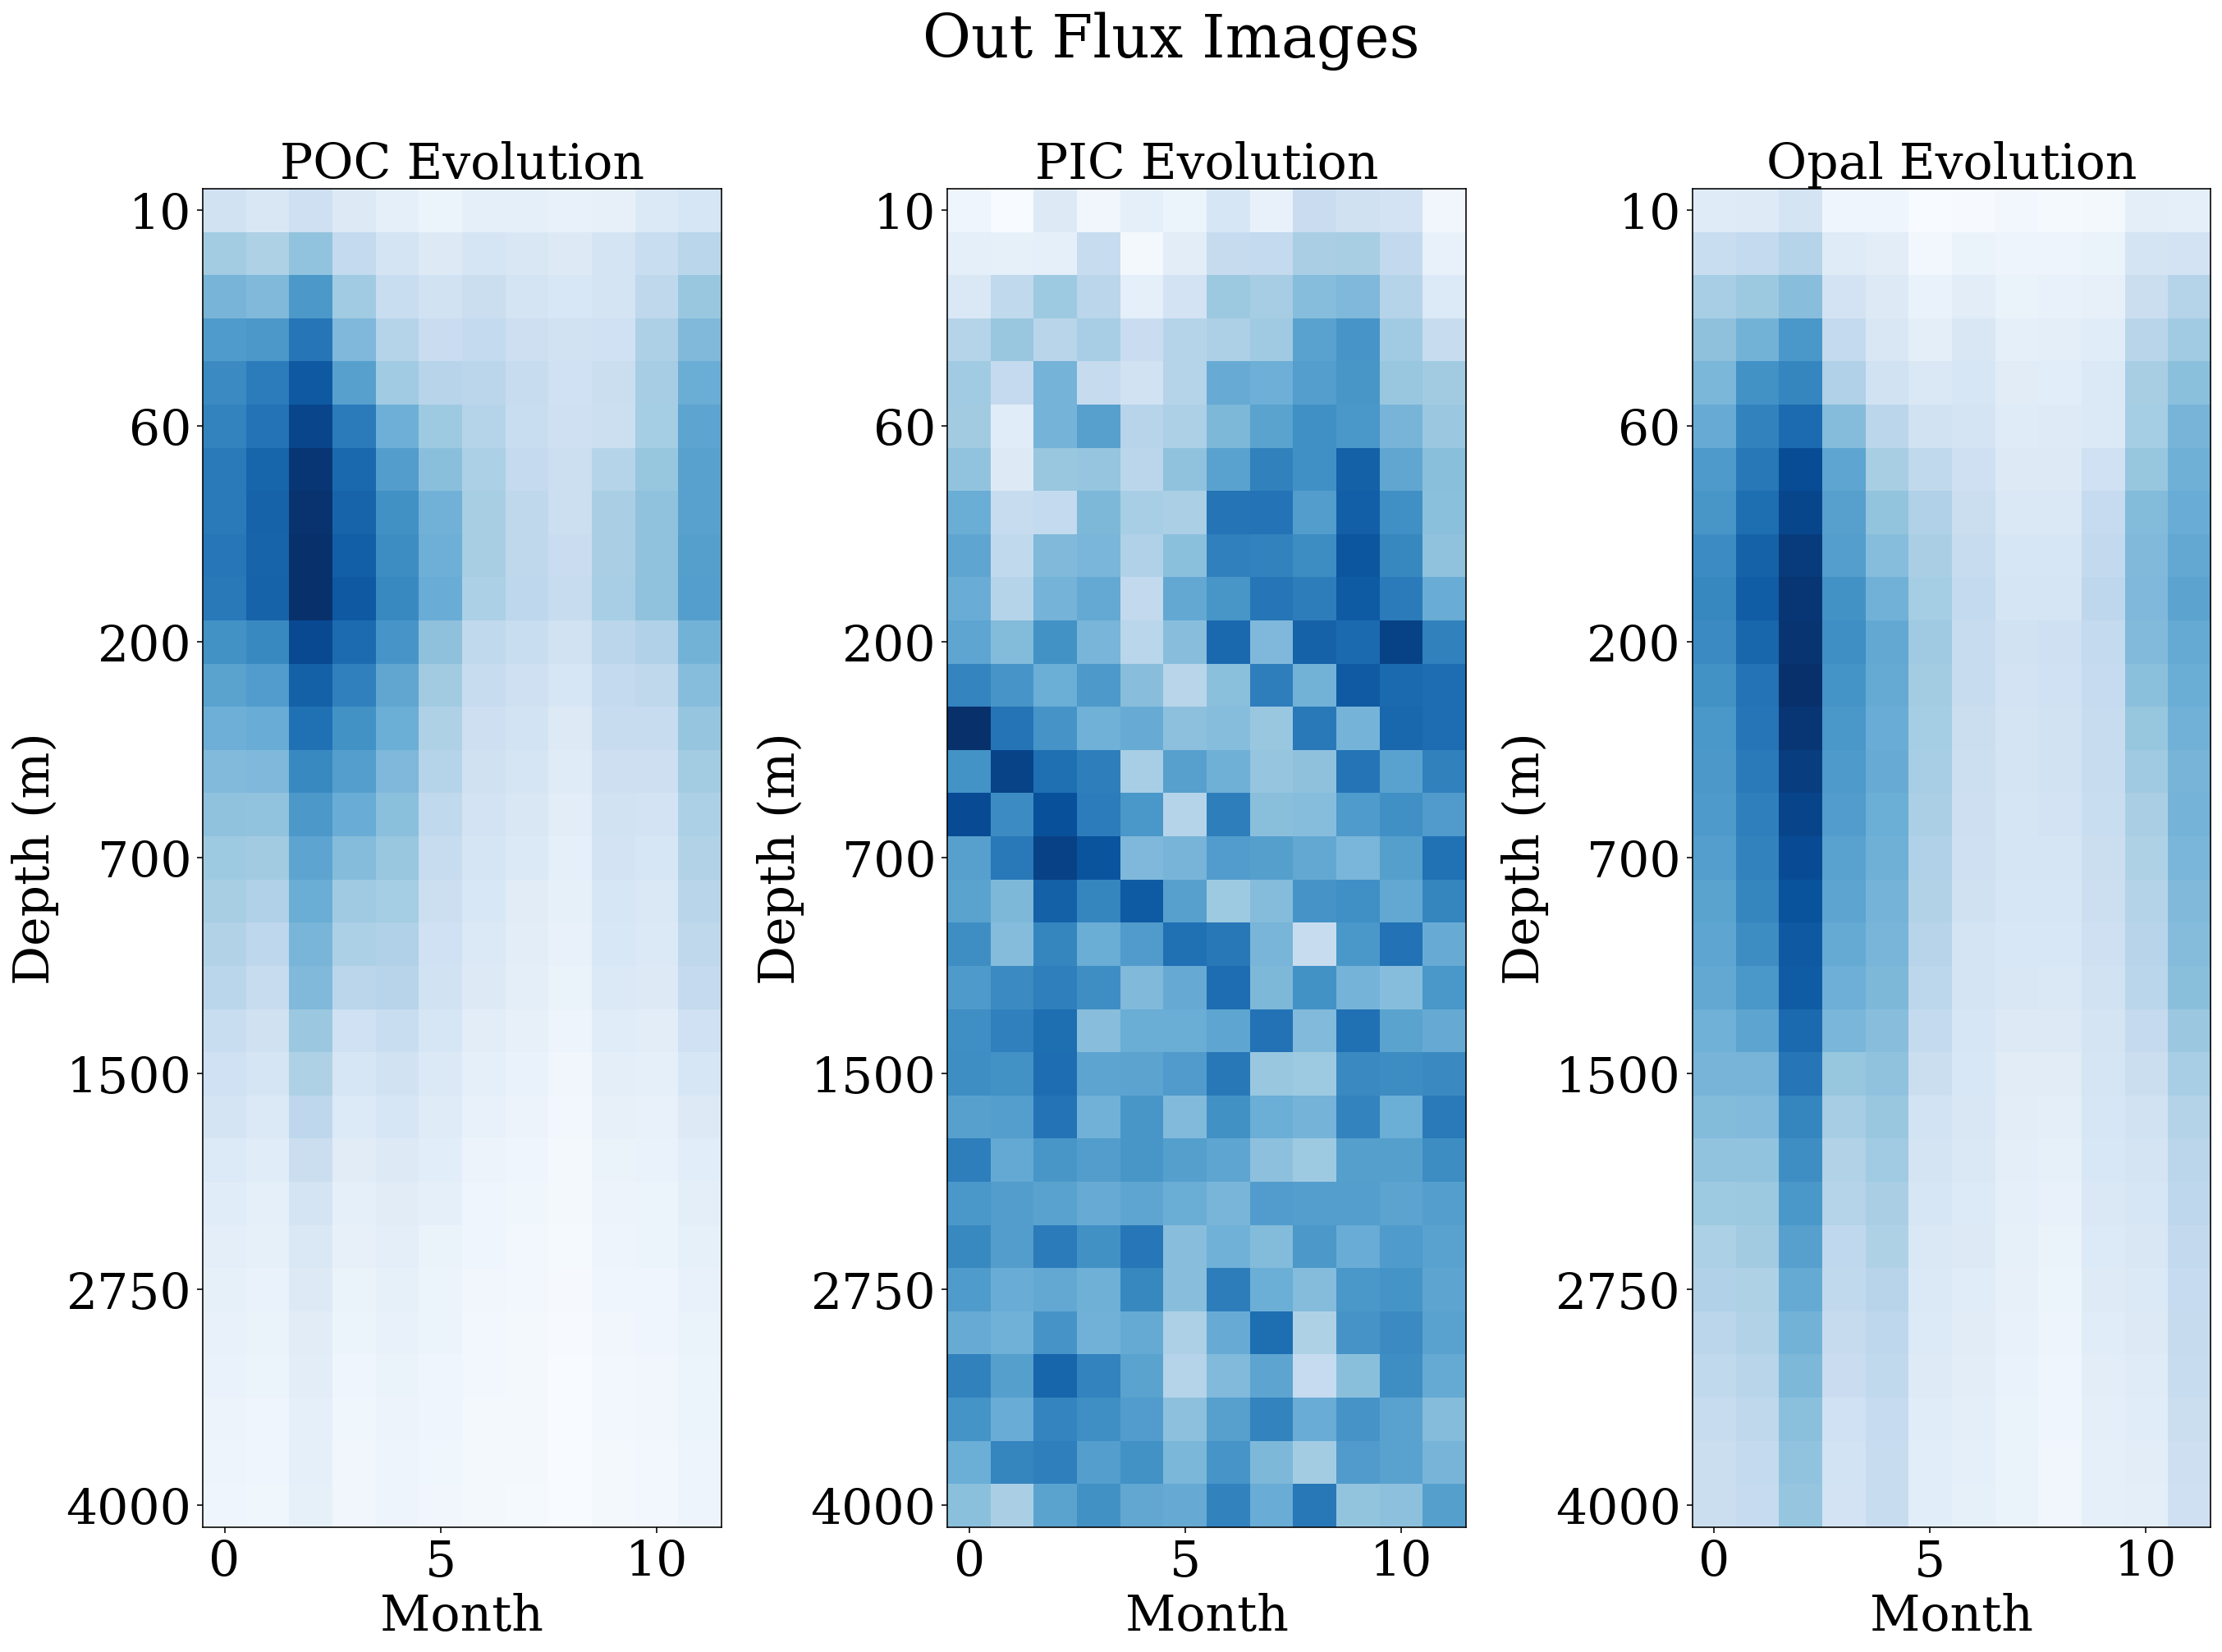

In [56]:
#setting the plotting parameters
params = {
    'image.cmap': 'gray',
    'axes.labelsize': 30, # fontsize for x and y labels (was 10)
    'axes.titlesize': 30,
    'font.size': 30, # was 10
    'legend.fontsize': 20, # was 10
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'figure.figsize': [24, 15],
    'font.family': 'serif',
}

#updating parameters for plotting
matplotlib.rcParams.update(params)

#setting up the graph structure
fig = plt.figure()
fig.suptitle("Out Flux Images") 
gs = matplotlib.gridspec.GridSpec(1, 3, width_ratios=[1.,1.,1.], height_ratios=[1.])
gs.update(wspace=0.05, hspace=0.05)

#plotting the annual particle size distribution 
ax1 = fig.add_subplot(gs[0])
ax1.imshow(poc_new,cmap ='Blues')
#ax1.set_yticks(depth_labeling[:31])
ax1.set_yticklabels(['','10','60','200','700','1500','2750','4000'])
ax1.set_ylabel('Depth (m)')
ax1.set_xlabel('Month')
ax1.set_title('POC Evolution')

ax2 = fig.add_subplot(gs[1])
ax2.imshow(pic,cmap = 'Blues')
ax2.set_yticklabels(['','10','60','200','700','1500','2750','4000'])
ax2.set_ylabel('Depth (m)')
ax2.set_xlabel('Month')
ax2.set_title('PIC Evolution')

ax3 = fig.add_subplot(gs[2])
ax3.imshow(opal, cmap='Blues')
ax3.set_yticklabels(['','10','60','200','700','1500','2750','4000'])
ax3.set_ylabel('Depth (m)')
ax3.set_xlabel('Month')
ax3.set_title('Opal Evolution')

plt.show()


## Latin Hypercube Sampling



In [5]:
from smt.sampling_methods import LHS
import lhsmdu

In [6]:
sampling_limits_main = np.array([[1.3, 2.3], [0.030, 0.65], [0.5,2.5],[0.1,3.0],[0.1,1.0],[0.020,0.60],
                            [2,10],[0.2,1],[0.030,0.25],[0.01,0.50],[1.0,7.0]])
bin_sampling_limits = np.array([[2e-8,4e-6],[0.1,180],[1,30]])
sampling_main = LHS(xlimits=sampling_limits_main)
bin_sampling = LHS(xlimits=bin_sampling_limits)

num = 1500
x = sampling_main(num)
bin_samples = bin_sampling(num)
np.set_printoptions(precision=4)
np.savetxt('parameter_sets_main.txt',x,fmt='%1.4g' + 'd0' )


In [7]:
np.savetxt('scaling_factors_for_bin.txt',bin_samples,fmt='%1.4g')

In [161]:
x.shape

(3, 13)

In [151]:
npp

array([[3.3367e-06],
       [6.8333e-07],
       [2.0100e-06]])

## Scailing the NPP , SiOH4 and TempC parameters

Here we develop the code to scale the NPP, SiOH4 and TempC parameters given the LHC samples given. 


In [165]:
npp = np.fromfile("SLAMS2.0_modelfiles/dataNPPvgpm.bin", dtype='>f8')
print("Original binary file: {}".format(npp))
print("Length of the npp file: {}".format(len(npp)))
#print("Type of the number: {}".format(type(npp[0])))
maximum_val = max(npp)
scaled_npp = 2e-8* (npp/maximum_val)
print ("Scaled binary file: {}".format(scaled_npp))

Original binary file: [5.5576e-07 5.5576e-07 0.0000e+00 ... 4.7418e-07 4.7418e-07 0.0000e+00]
Length of the npp file: 1095
Scaled binary file: [1.5032e-08 1.5032e-08 0.0000e+00 ... 1.2826e-08 1.2826e-08 0.0000e+00]


In [169]:
packed_scaled_npp = struct.pack('>'+str(len(scaled_npp)) + 'd', *scaled_npp)

with open("SLAMS2.0_modelfiles/dataNPPvgpmScaled.bin", 'rb+') as f:
    f.write(packed_scaled_npp)

check = np.fromfile("SLAMS2.0_modelfiles/dataNPPvgpmScaled.bin", dtype='>f8')
check

array([1.5032e-08, 1.5032e-08, 0.0000e+00, ..., 1.2826e-08, 1.2826e-08,
       0.0000e+00])